<a id='Index'></a>

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> Index </h1></span>

Section List

<a href='#Import-Libraries'> 1. Import Libraries + Settings</a>

<a href='#Load-Data'> 2. Load Data </a>

<a href='#DT-pruning'> 3. Decision Tree (DT) Classifier </a>

<a href='#Boosting'> 4. Gradient Boosted DT  </a>

<a href='#MLP'> 5. Multi-layer Perceptrons </a>

<a href='#kNN'> 6. k-Nearest Neighbors </a>

<a href='#SVC'> 7. C-Support Vector Classifier  </a>





<a id='Import-Libraries'></a>
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> Import Libraries </h1></span>
<a href='#Index'> Back to Index</a>

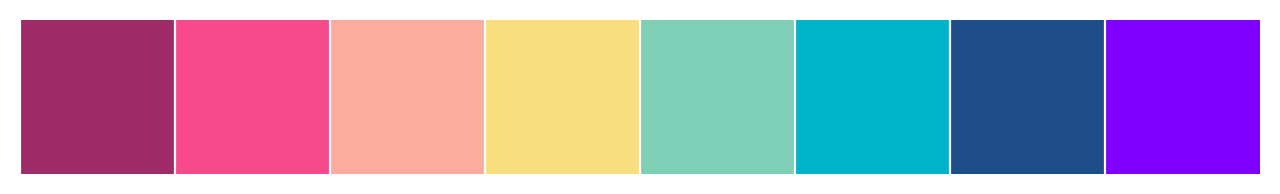

In [1]:
import os
os.environ["dataset"] = "rental_listing"

# read raw input
import json

# dataframe manipulation
import pandas as pd 
import numpy as np
import re

# metric
from sklearn.metrics import log_loss, confusion_matrix

# validation curve and learning curve
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import validation_curve, learning_curve, HalvingGridSearchCV

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from utils import *

# ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# other stuff
import os
import time
import csv
import random
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

np.random.seed(888) # set seed to split data into training and testing later.

# set stype
plt.style.use("seaborn-darkgrid")
%config InlineBackend.figure_format = 'retina'
my_palette = ['#9F2B68', '#f64a8a', '#fdab9f', '#F8DE7E', '#7dcfb6', '#00b2ca', '#1d4e89', '#7F00FF'] 
sns.set_palette(palette=my_palette)
sns.palplot(sns.color_palette(my_palette))

<a id='Load-Data'></a>
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> Loading Data </h1></span>
<a href='#Index'> Back to Index</a>

In [2]:
### Load Data
DATA_PATH = "datasets/processed/rental_listing/"

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
display(train_df.head())
display(test_df.head())

# Split labels from dataframe
X_train = train_df.loc[:, train_df.columns != 'interest_level']
y_train = train_df['interest_level']

X_test = test_df.loc[:, test_df.columns != 'interest_level']
y_test = test_df['interest_level']

# DICTIONARY FOR TUNED MODEL PERFORMANCE COMPARISON
MODEL_RES = {"model_name": [], "metric_score": [], "params": [], "train_time": [], "infer_time":[]}

,bathrooms,bedrooms,latitude,longitude,price,photos_num,description_len,features_len,Elevator,Cats Allowed,...,Balcony,Swimming Pool,Laundry In Building,New Construction,Terrace,studio,created_delta,building_id_ct,manager_id_ct,interest_level
0,1.0,1,40.7108,-73.9539,2400,12,81,7,0,1,...,0,0,0,0,0,1,-2054187.3,5,112,1
1,1.0,2,40.7575,-73.9625,3495,6,124,6,1,0,...,0,0,0,0,0,1,-2068080.1,71,93,1
2,1.5,3,40.7145,-73.9425,3000,5,99,0,0,0,...,0,0,0,0,0,1,-1984353.6,3,90,1
3,1.0,0,40.7439,-73.9743,2795,4,46,4,1,0,...,0,0,0,0,0,1,-1951257.7,86,55,0
4,1.0,3,40.7348,-73.9865,7200,5,137,6,1,0,...,0,0,0,0,0,1,-1950485.4,110,169,0


,bathrooms,bedrooms,latitude,longitude,price,photos_num,description_len,features_len,Elevator,Cats Allowed,...,Balcony,Swimming Pool,Laundry In Building,New Construction,Terrace,studio,created_delta,building_id_ct,manager_id_ct,interest_level
0,1.0,3,40.7451,-73.9792,3150,4,28,2,0,1,...,0,0,0,0,0,1,-1969031.4,4,61,1
1,1.0,1,40.7334,-74.0047,4875,9,41,5,1,1,...,0,0,0,0,0,1,-1959488.6,101,11,0
2,1.0,2,40.7091,-74.0055,3670,8,41,4,1,0,...,0,0,0,0,0,1,-2302375.5,8286,30,0
3,1.0,2,40.7993,-73.9604,4500,4,47,7,0,1,...,0,0,0,0,0,1,-2010671.2,13,13,0
4,2.0,3,40.7548,-73.9944,4795,6,128,9,1,0,...,0,0,0,0,0,1,-2537873.6,85,42,0


In [3]:
# get a value counts of training_data label distribution
display(y_train.value_counts())

0    27813
1     9084
2     3103
Name: interest_level, dtype: int64

<a id='DT-pruning'></a>
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> Decision Tree (DT) classifier </h1></span>
<a href='#Index'> Back to Index</a>

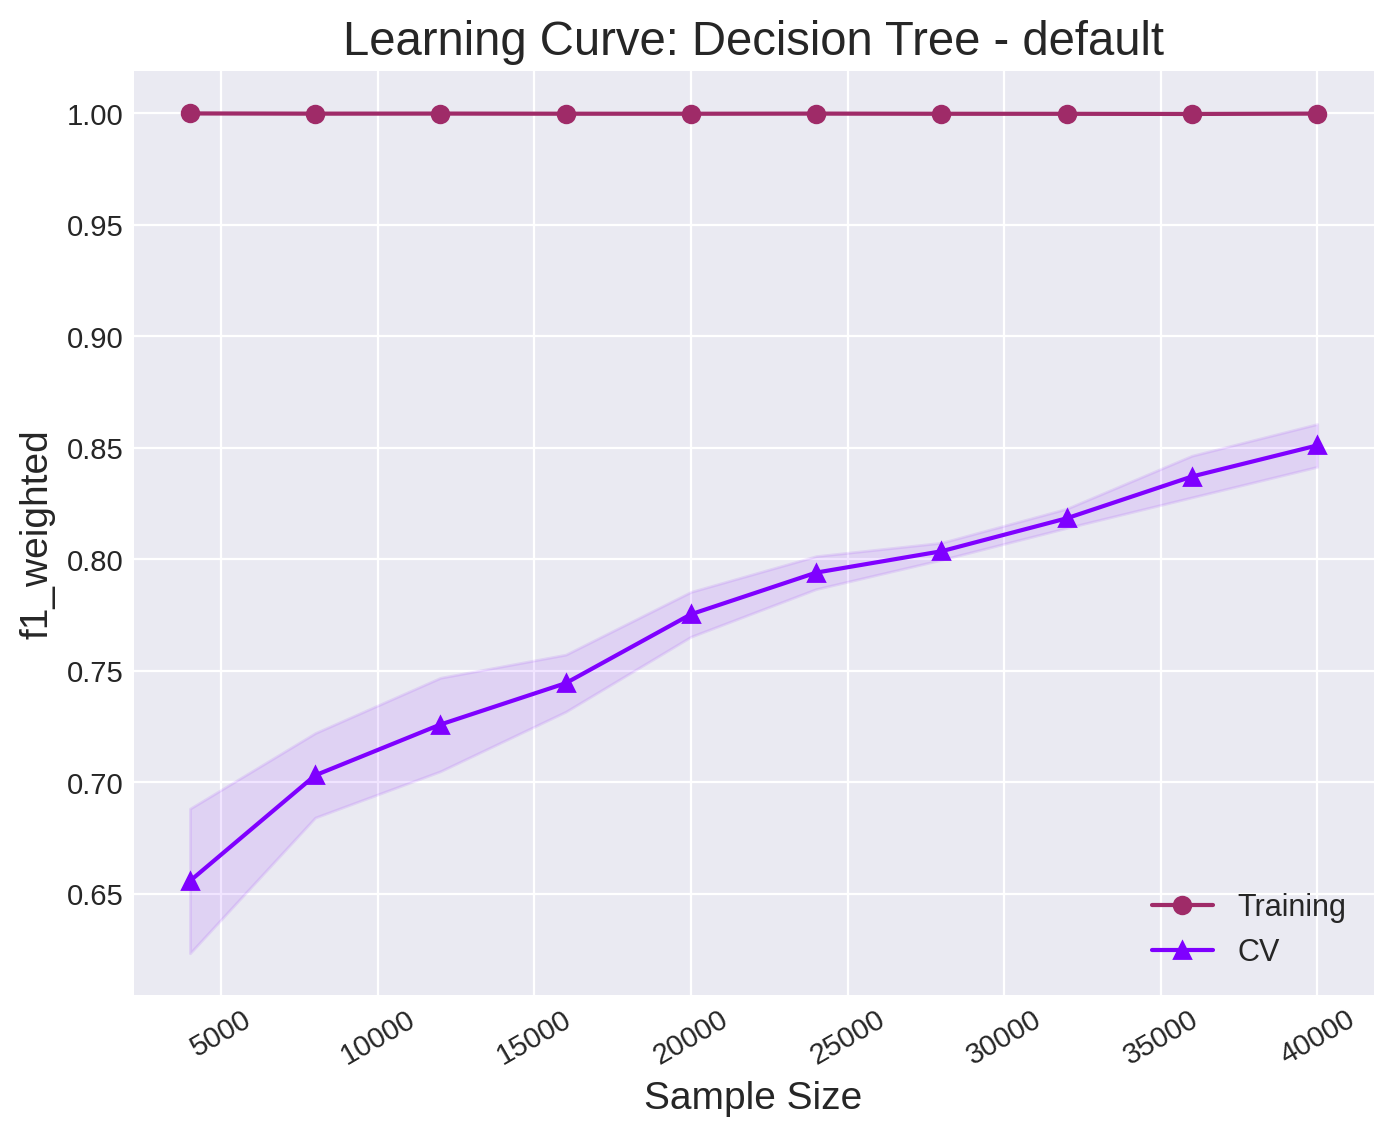

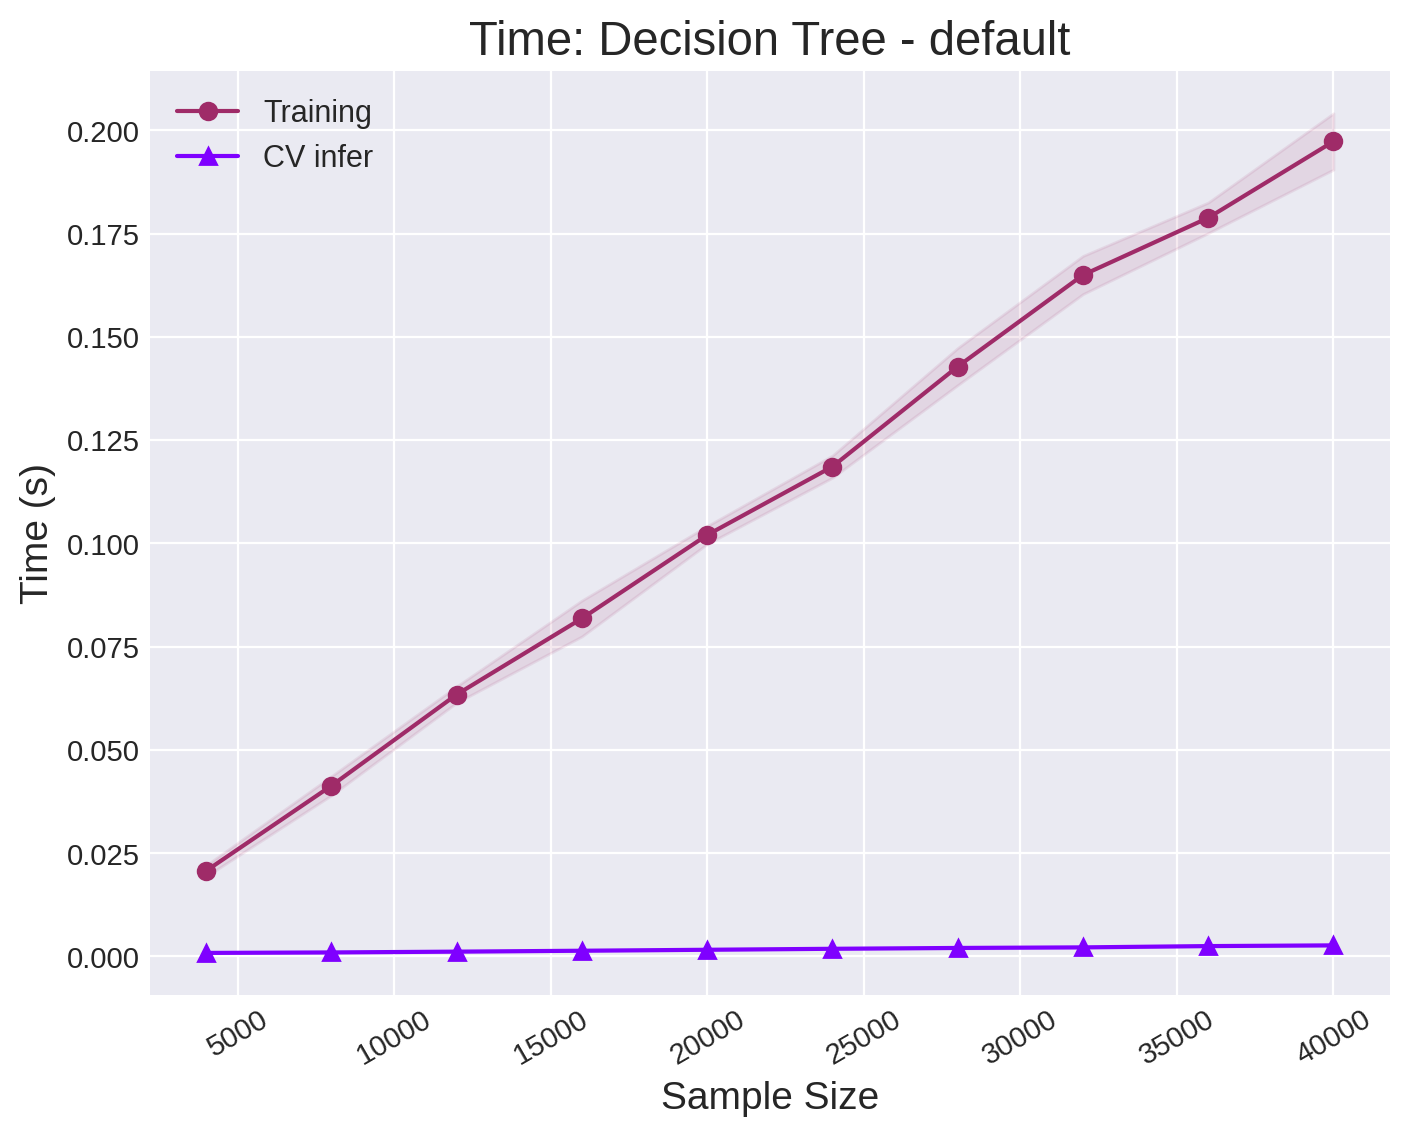

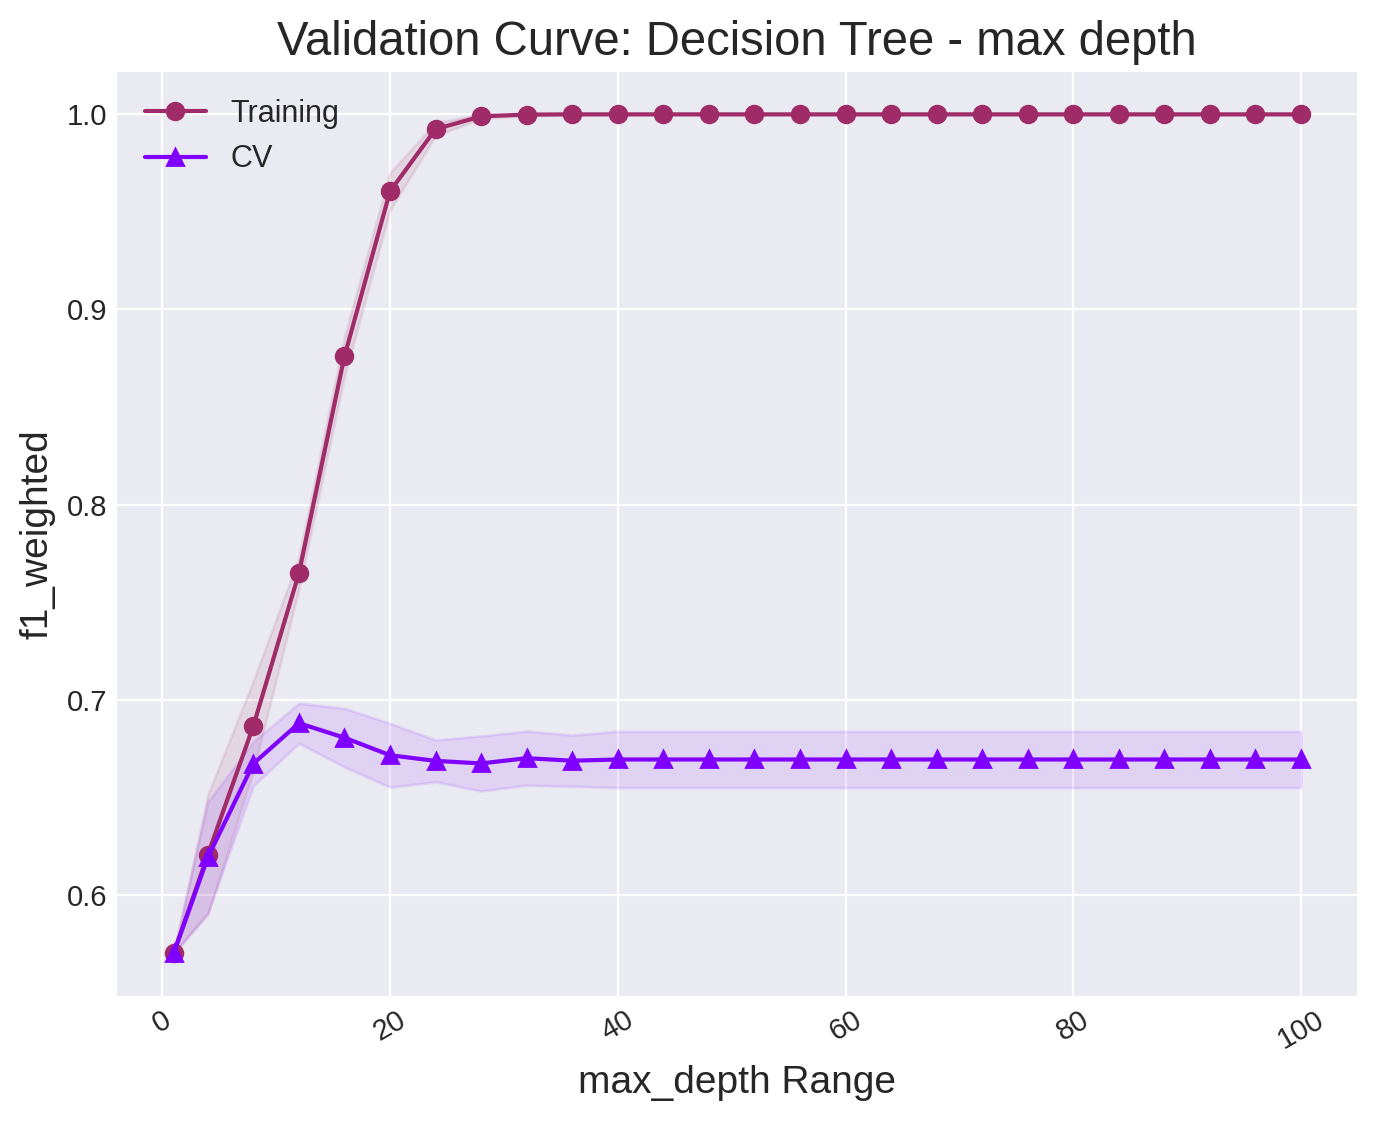

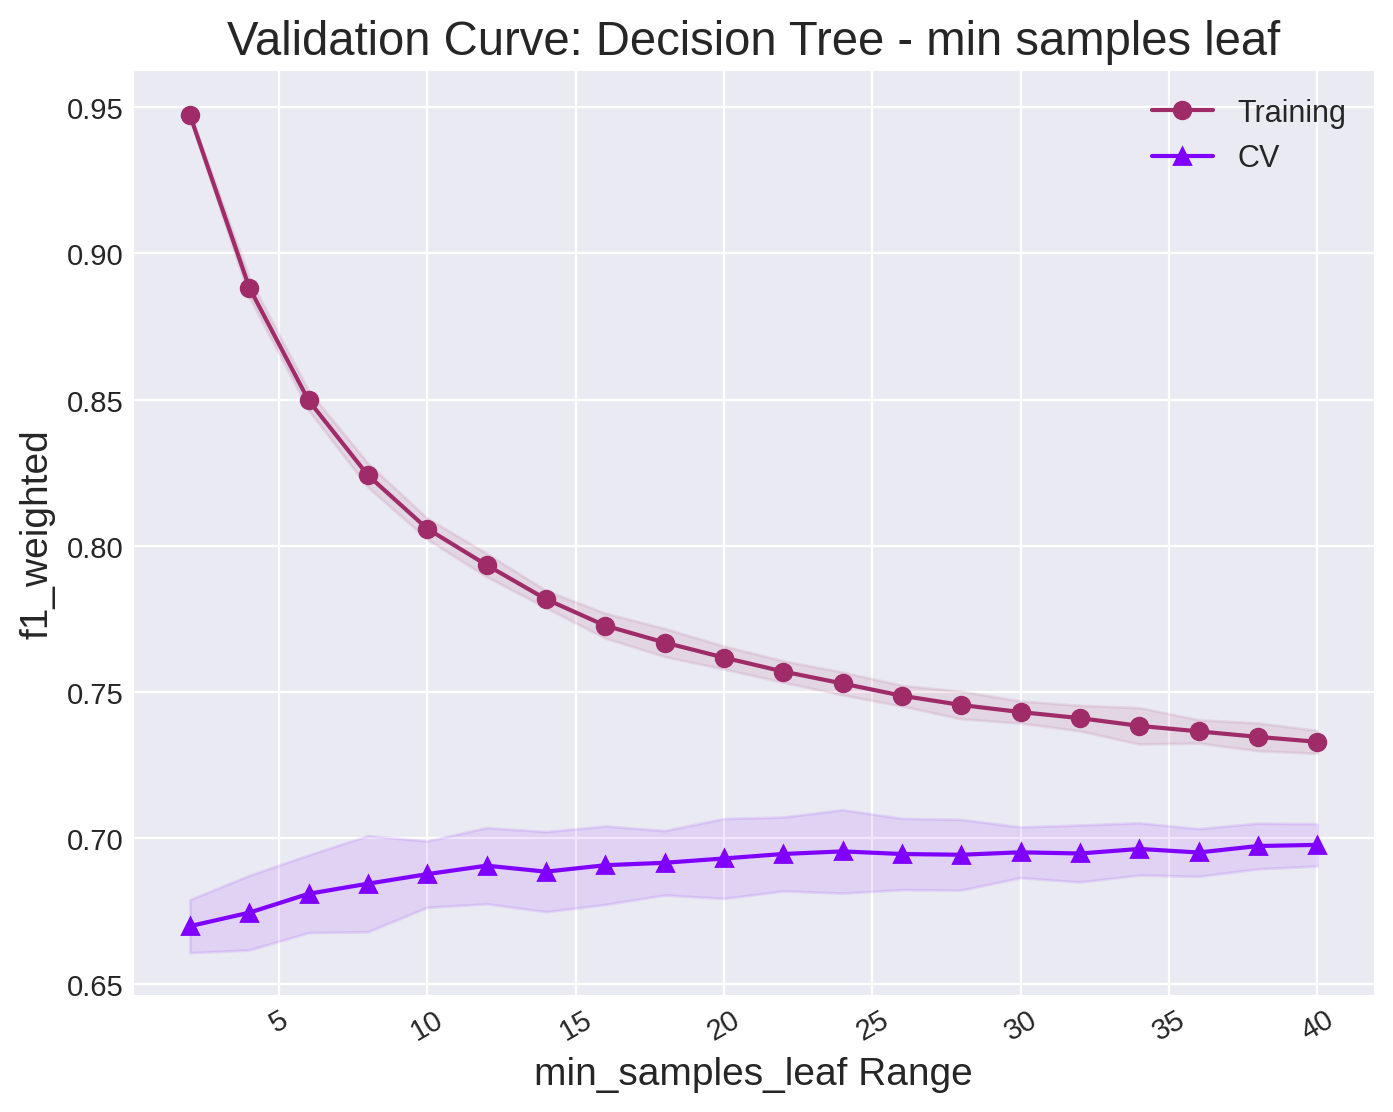

CPU times: user 53.8 s, sys: 1.24 s, total: 55.1 s
Wall time: 53.4 s


In [4]:
%%time
# experiment with max_depth and min sample leaf
max_depth_range = list(range(0, 101, 4))
max_depth_range[0] = 1
min_sample_leaf_range = list(range(2,42,2))
train_sizes = np.linspace(0.1, 1, 10)

clf = DecisionTreeClassifier(random_state=888, criterion="log_loss")

# plot Learning curve for the default DT
plot_learning_curve(
    clf,
    X_train.values,
    y_train.values,
    train_sizes=train_sizes,
    metric="f1_weighted",
    title="Decision Tree - default"
)

# experiment with max depth
plot_validation_curve(
    clf,
    X_train.values,
    y_train.values,
    param_name='max_depth',
    param_range=max_depth_range,
    metric="f1_weighted",
    title="Decision Tree - max depth"
)

# experiment with min samples in leaf node
plot_validation_curve(
    clf,
    X_train.values,
    y_train.values,
    param_name='min_samples_leaf',
    param_range=min_sample_leaf_range,
    metric="f1_weighted",
    title="Decision Tree - min samples leaf"
)

In [5]:
%%time
# optimize the decision tree by searching max_depth between 10 and 40, min samples leaf between 5 and 20
param_grid = {
    'min_samples_leaf': range(10,41), 
    'max_depth': range(5, 20)
    }

tuned_dt_clf = HalvingGridSearchCV(
   estimator = DecisionTreeClassifier(random_state=888),
   param_grid=param_grid,
   cv=5,
   factor=2
   )
tuned_dt_clf.fit(X_train, y_train)
print("With HalvingGridSearchCV, best parameters are: \n", tuned_dt_clf.best_params_)

With HalvingGridSearchCV, best parameters are: 
 {'max_depth': 8, 'min_samples_leaf': 39}
CPU times: user 18.9 s, sys: 7.79 ms, total: 18.9 s
Wall time: 18.9 s


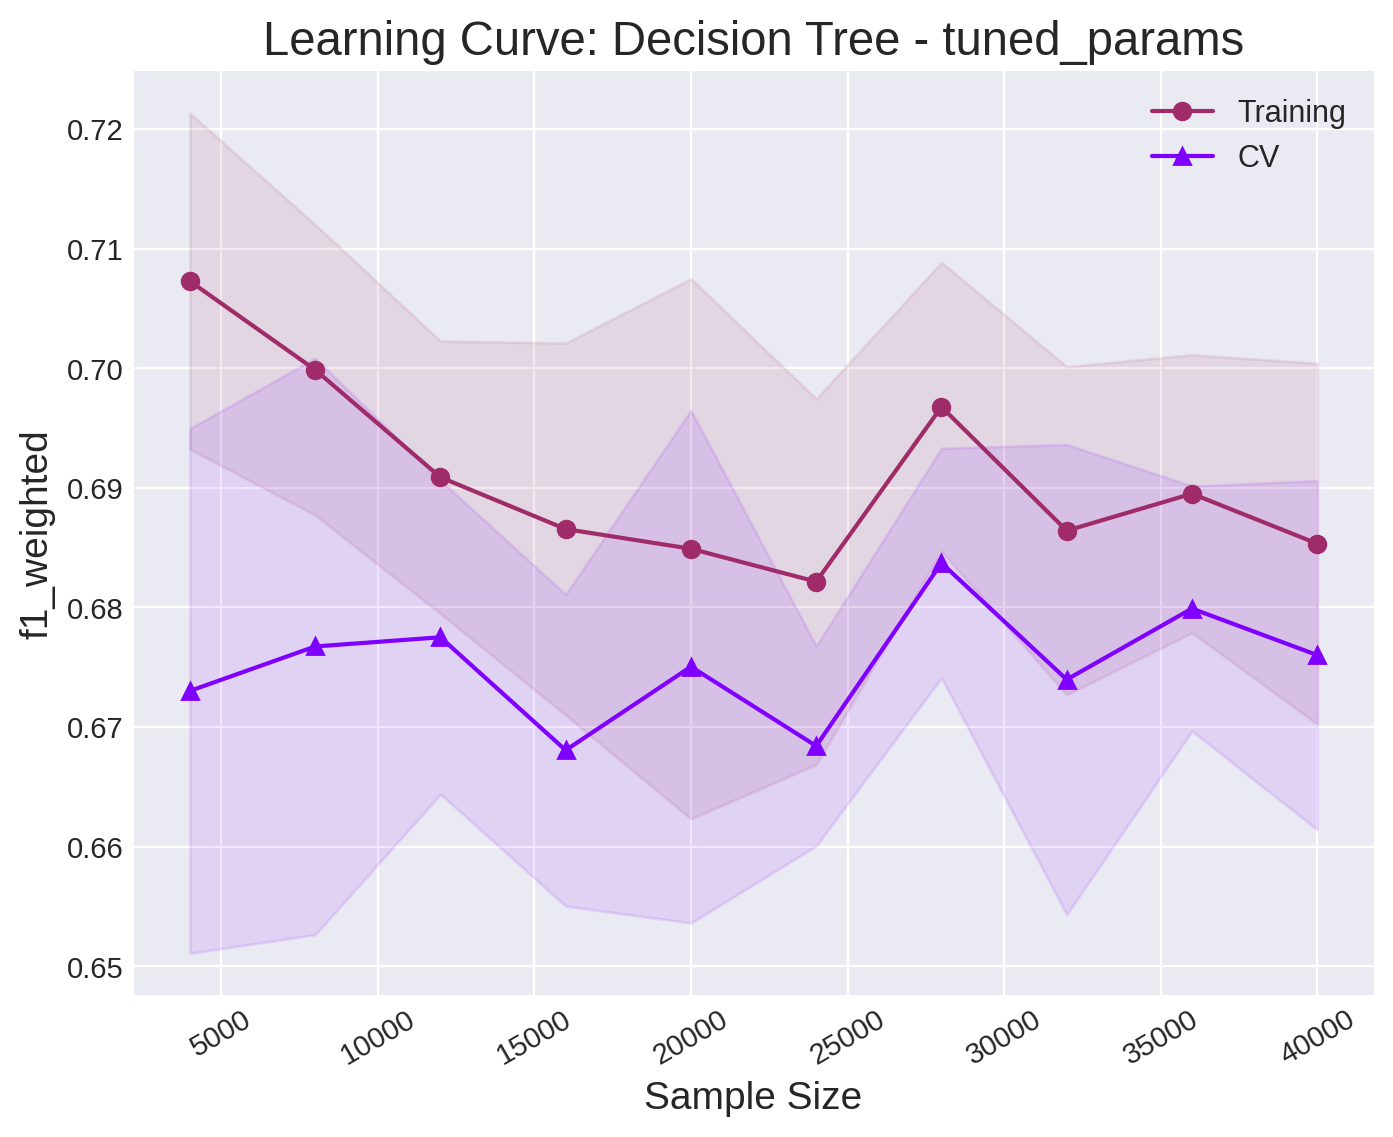

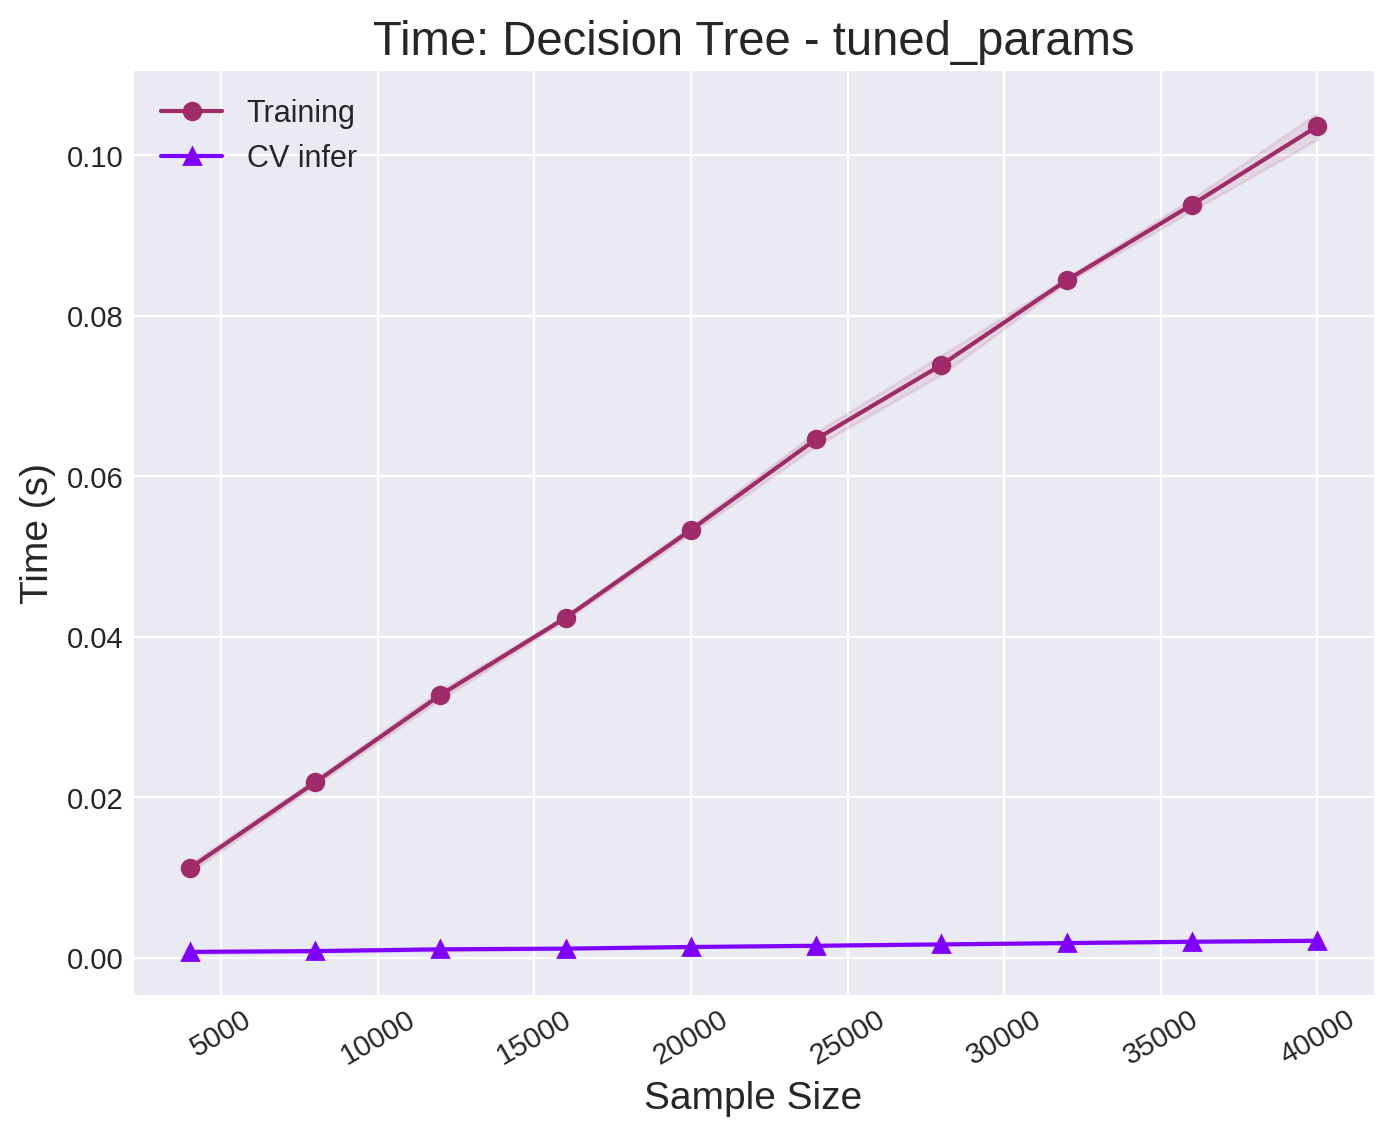

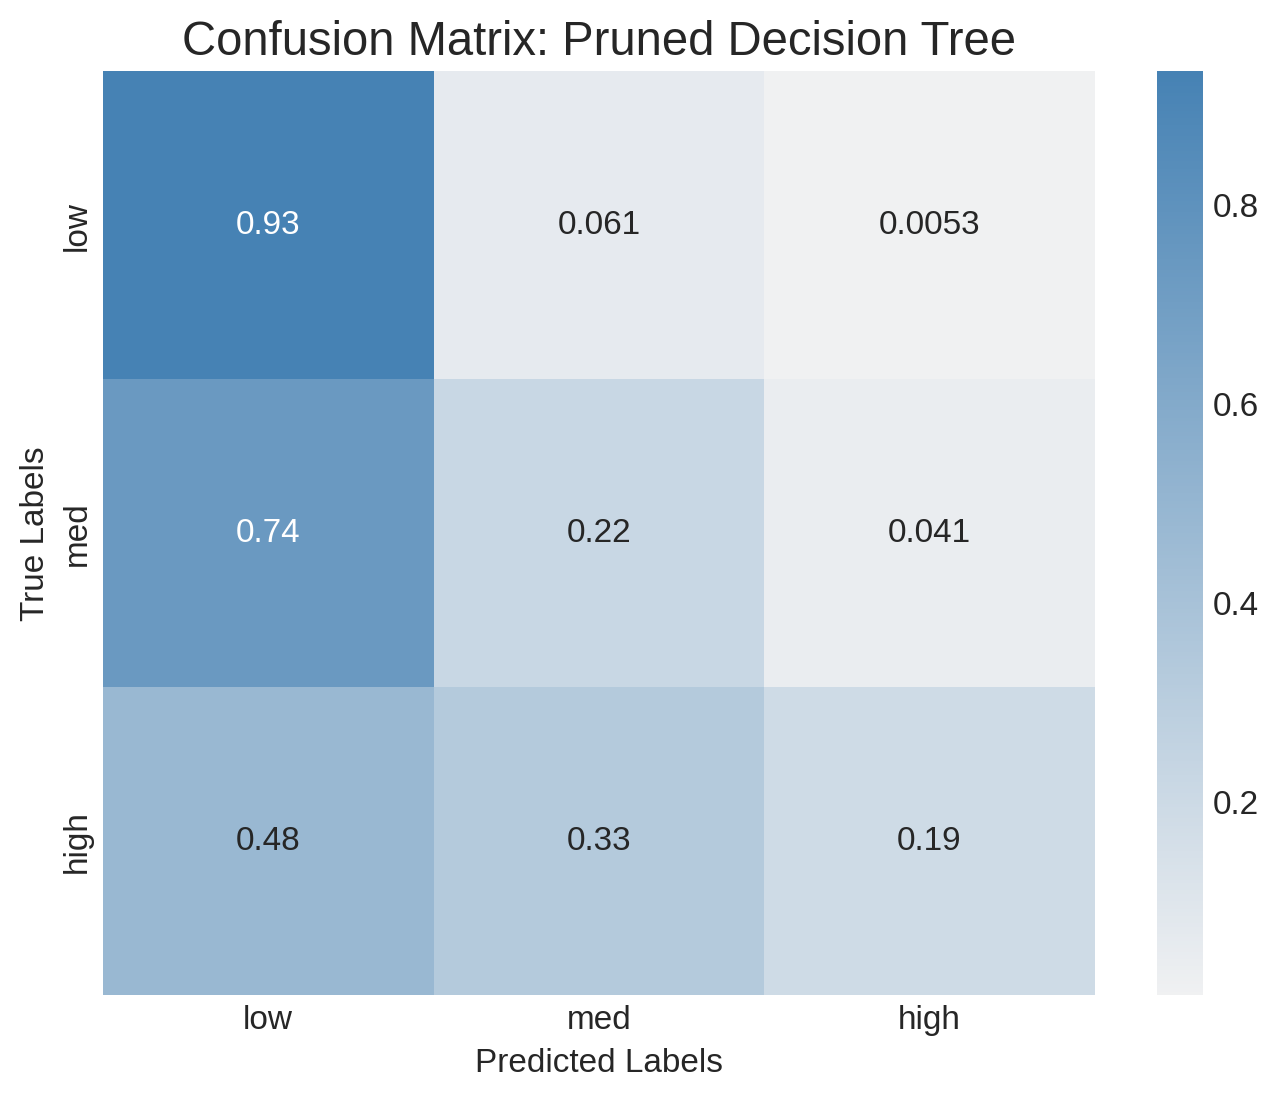

CPU times: user 4.27 s, sys: 872 ms, total: 5.14 s
Wall time: 3.98 s


In [6]:
%%time
# Get learning curve 
clf = DecisionTreeClassifier(
    random_state=888,
    criterion="log_loss",
    max_depth=tuned_dt_clf.best_params_['max_depth'],
    min_samples_leaf=tuned_dt_clf.best_params_['min_samples_leaf']
)

# plot Learning curve for the default DT with (supposedly) optimal max_depth and min_samples_leaf
plot_learning_curve(
    clf,
    X_train.values,
    y_train.values,
    train_sizes=train_sizes,
    metric="f1_weighted",
    title="Decision Tree - tuned_params"
)

# fit DT clf on the whole training data and making predictions
train_start_time = time.time()
clf.fit(X_train.values, y_train.values)
train_time = time.time() - train_start_time

infer_start_time = time.time()
test_preds = clf.predict(X_test.values)
infer_time = time.time() - infer_start_time

metric_score = f1_score(y_true=y_test, y_pred=test_preds, average='weighted')

conf_mat = confusion_matrix(
    y_true=y_test.values,
    y_pred=test_preds,
    labels = [0, 1, 2]
)

plot_confusion_matrix(
    conf_mat=conf_mat,
    normalize=True,
    classes=['low', 'med', 'high'],
    title="Pruned Decision Tree")

In [7]:
MODEL_RES['model_name'].append("Pruned Decision Tree")
MODEL_RES['metric_score'].append(metric_score)
MODEL_RES['params'].append(tuned_dt_clf.best_params_)
MODEL_RES['train_time'].append(train_time)
MODEL_RES['infer_time'].append(infer_time)

<a id='Boosting'></a>
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Histogram-based Gradient Boosted DT classifier </h1></span>
<a href='#Index'> Back to Index</a>

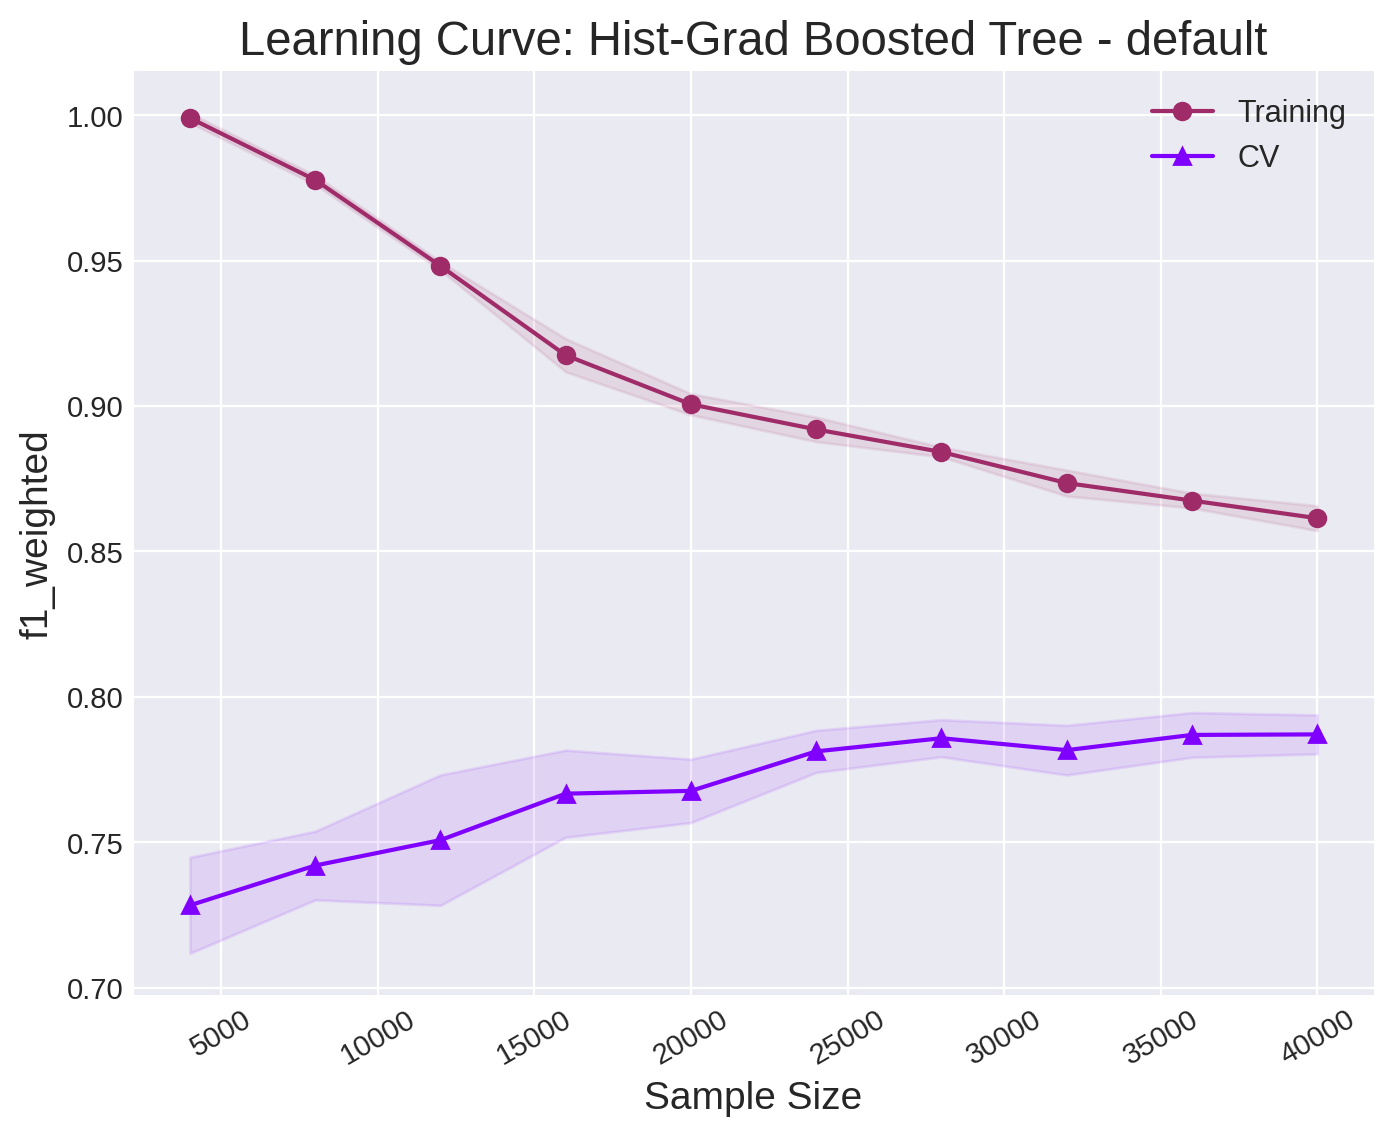

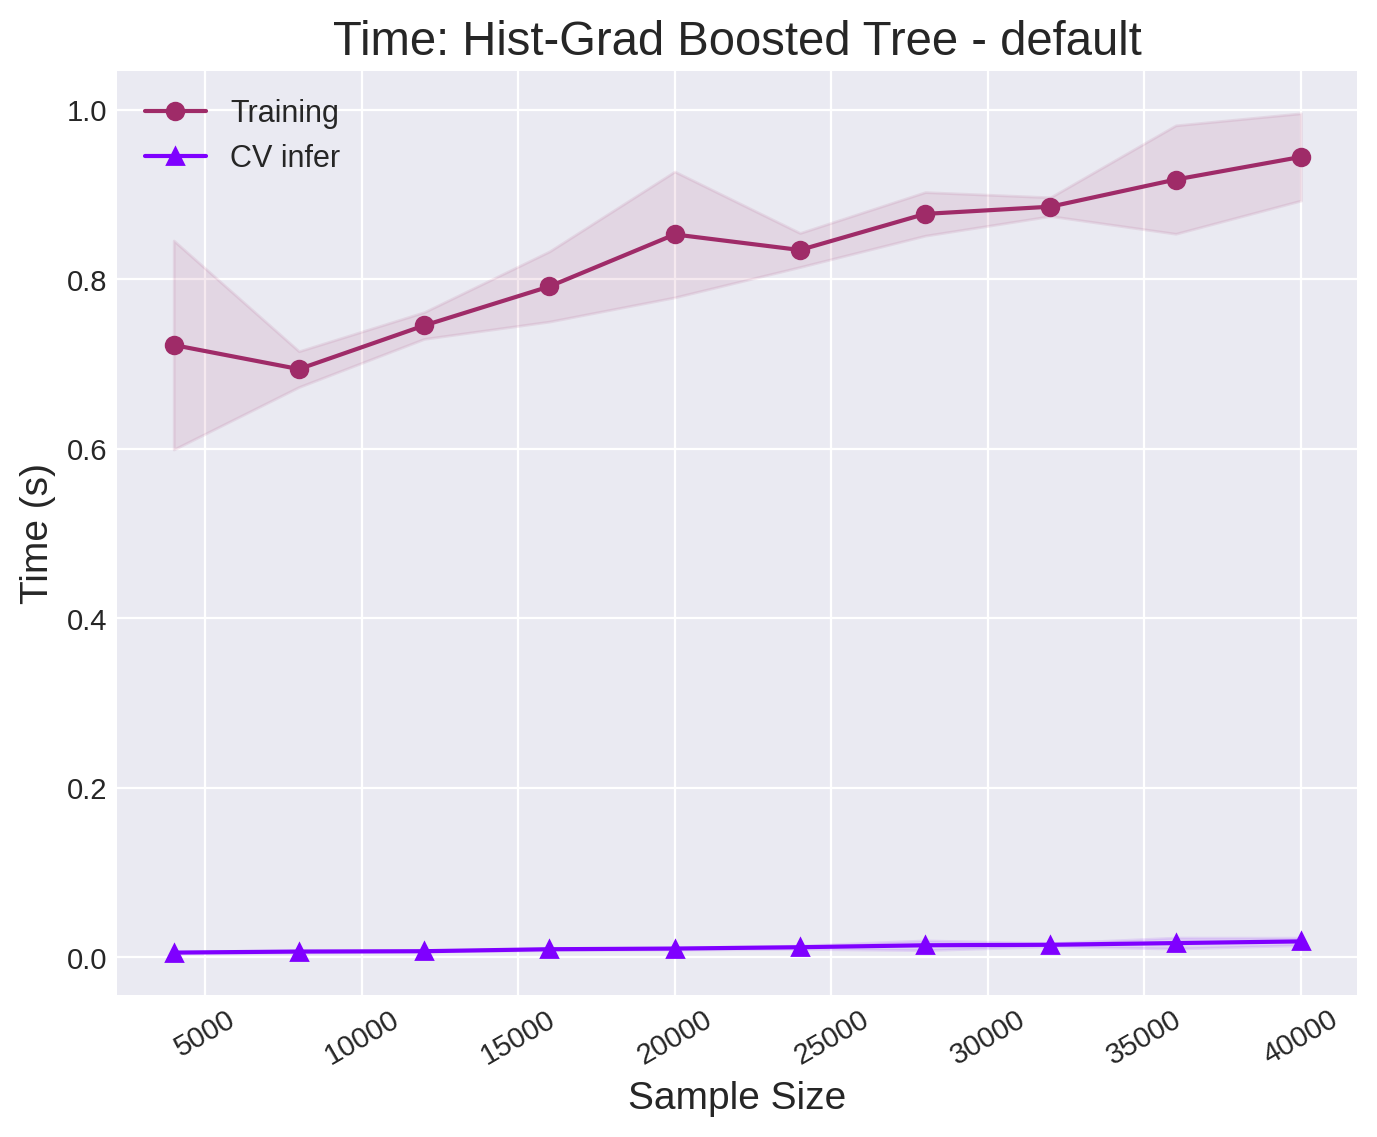

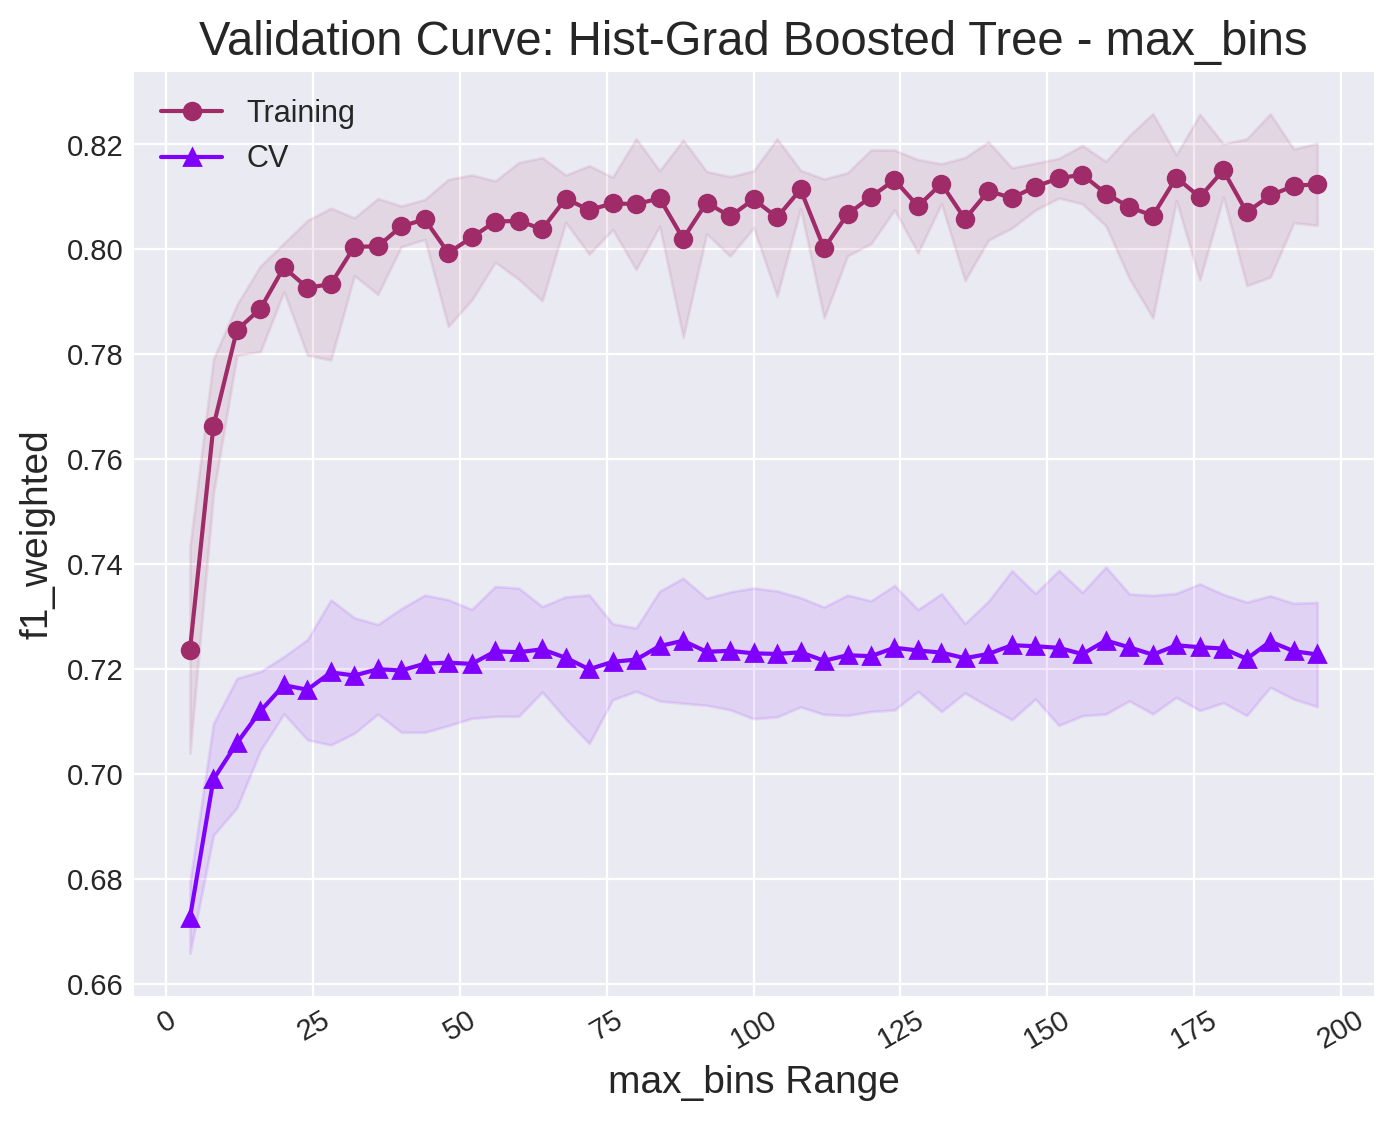

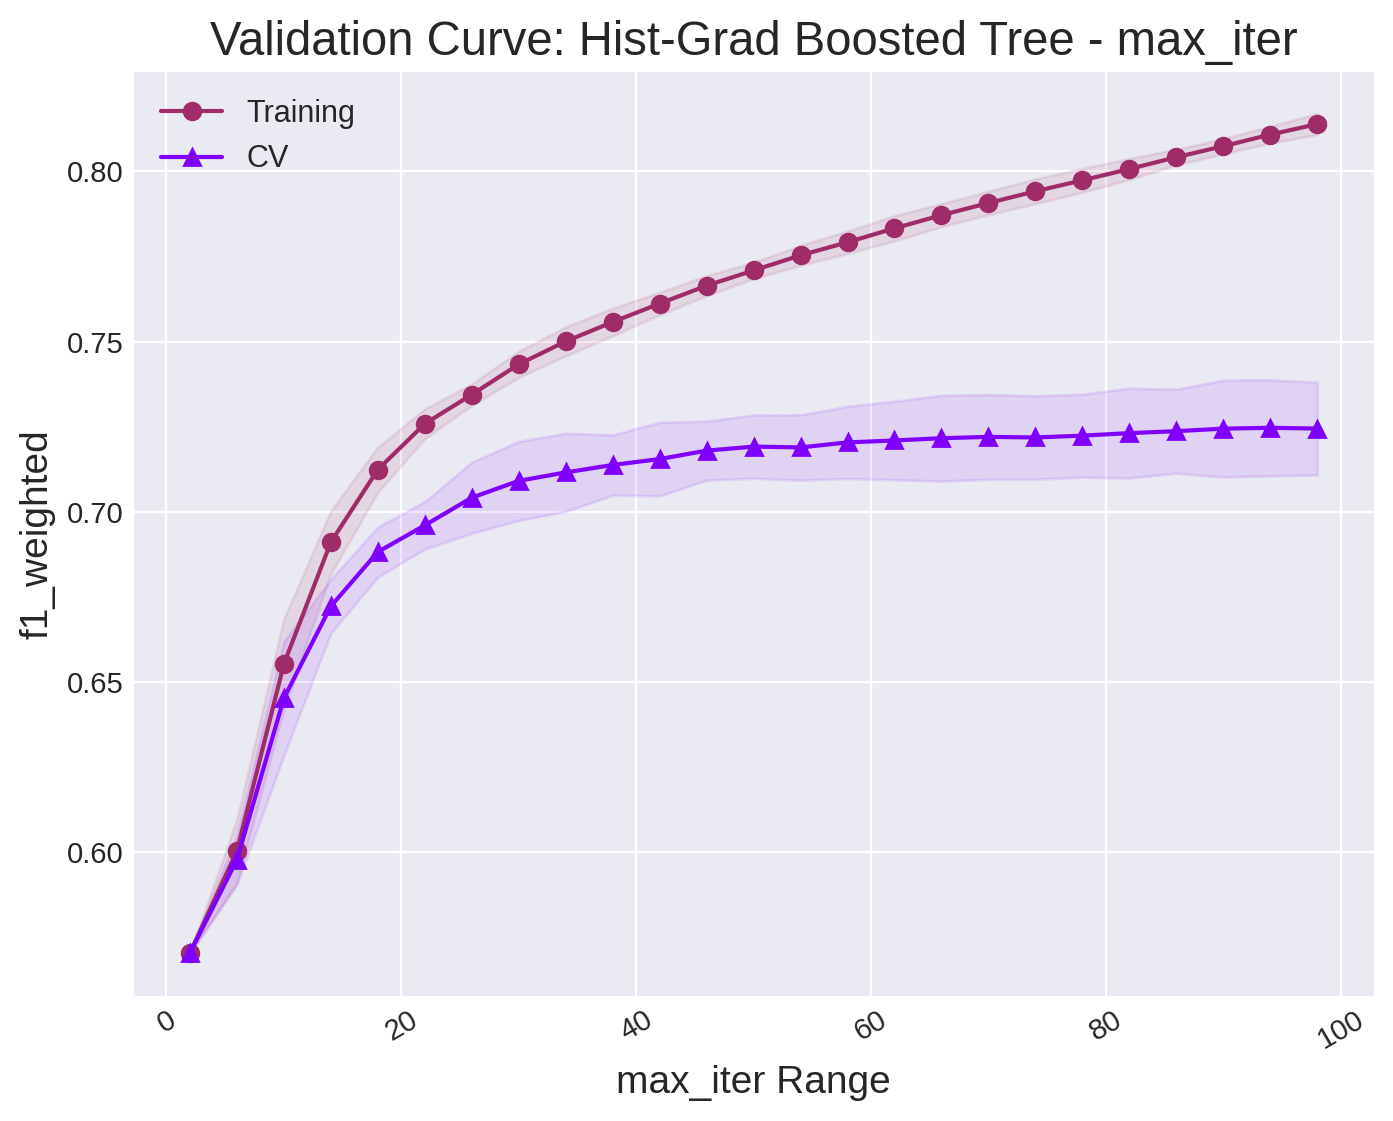

CPU times: user 1h 26min 37s, sys: 11.8 s, total: 1h 26min 49s
Wall time: 5min 42s


In [8]:
%%time
# experiment with max_bins and max_iter
max_bins_range = list(range(0, 200, 4))
max_bins_range[0] = 1
max_iter_range = list(range(2,100,4))
train_sizes = np.linspace(0.1, 1, 10)

clf = HistGradientBoostingClassifier(random_state=888, loss="log_loss")

# plot Learning curve for the default DT 
plot_learning_curve(
    clf,
    X_train.values,
    y_train.values,
    train_sizes=train_sizes,
    metric="f1_weighted",
    title="Hist-Grad Boosted Tree - default"
)


# experiment with max_bins
plot_validation_curve(
    clf,
    X_train.values,
    y_train.values,
    param_name='max_bins',
    param_range=max_bins_range,
    metric="f1_weighted",
    title="Hist-Grad Boosted Tree - max_bins"
)


# experiment with max_iter
plot_validation_curve(
    clf,
    X_train.values,
    y_train.values,
    param_name='max_iter',
    param_range=max_iter_range,
    metric="f1_weighted",
    title="Hist-Grad Boosted Tree - max_iter"
)

In [9]:
%%time
# optimize the decision tree by searching max_bins between 40 and 60, max_iter between 30 and 50
param_grid = {
    'max_bins': range(40,61), 
    'max_iter': range(30, 51)
    }

tuned_boostdt_clf = HalvingGridSearchCV(
   estimator = HistGradientBoostingClassifier(random_state=888, loss="log_loss"),
   param_grid=param_grid,
   cv=5,
   factor=2
   )
tuned_boostdt_clf.fit(X_train, y_train)
print("With HalvingGridSearchCV, best parameters are: \n", tuned_boostdt_clf.best_params_)


With HalvingGridSearchCV, best parameters are: 
 {'max_bins': 56, 'max_iter': 41}
CPU times: user 1h 52min 54s, sys: 19.3 s, total: 1h 53min 14s
Wall time: 7min 12s


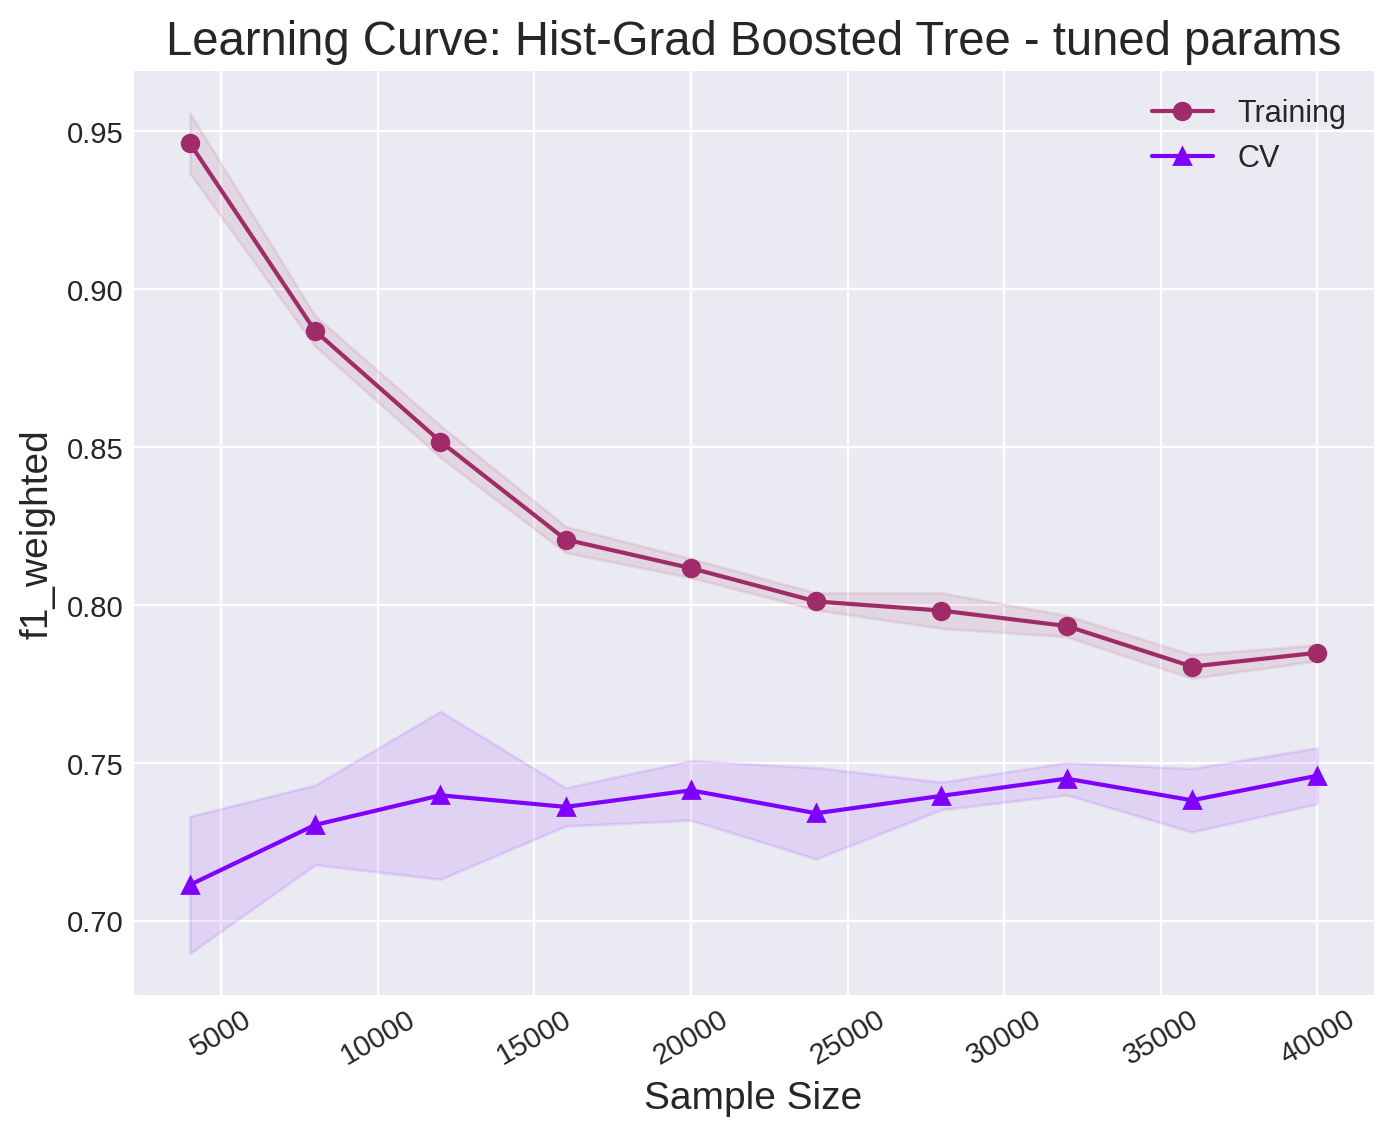

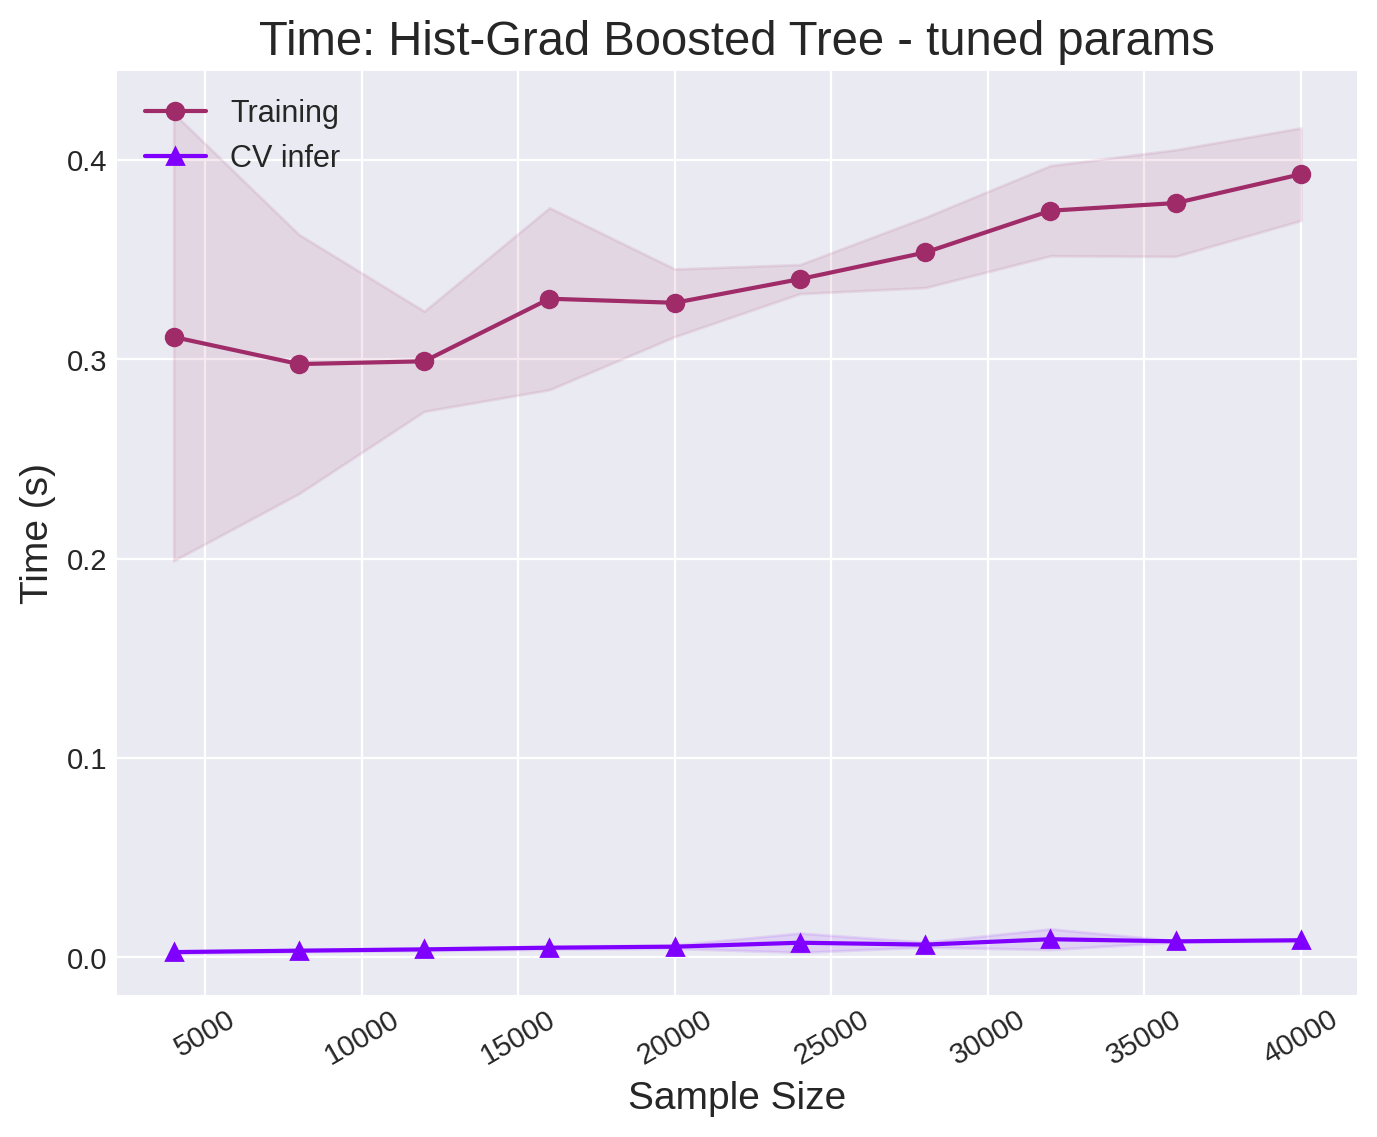

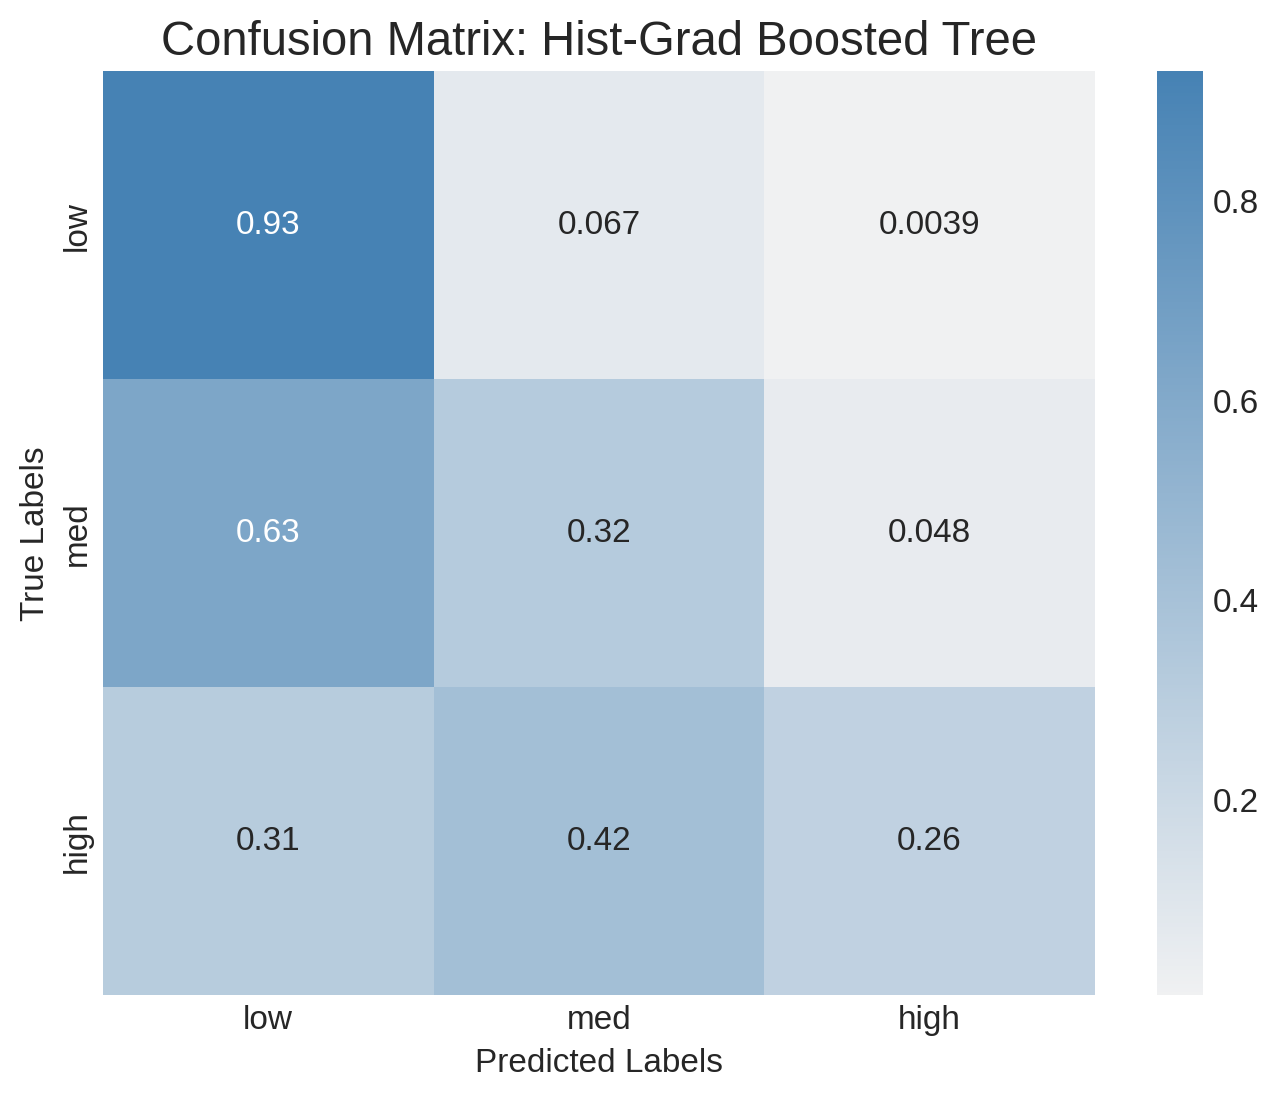

In [10]:
### Train clf on the whole training data and get learning curve

clf = HistGradientBoostingClassifier(
    random_state=888,
    loss="log_loss",
    max_bins=tuned_boostdt_clf.best_params_['max_bins'],
    max_iter=tuned_boostdt_clf.best_params_['max_iter']
)

# plot Learning curve for the boosted DT  with the (supposedly) optimal params
plot_learning_curve(
    clf,
    X_train.values,
    y_train.values,
    train_sizes=train_sizes,
    metric="f1_weighted",
    title="Hist-Grad Boosted Tree - tuned params"
)

# fit DT clf on the whole training data and making predictions
train_start_time = time.time()
clf.fit(X_train.values, y_train.values)
train_time = time.time() - train_start_time

infer_start_time = time.time()
test_preds = clf.predict(X_test.values)
infer_time = time.time() - infer_start_time

metric_score = f1_score(y_true=y_test, y_pred=test_preds, average='weighted')

conf_mat = confusion_matrix(
    y_true=y_test.values,
    y_pred=test_preds,
    labels = [0, 1, 2]
)

plot_confusion_matrix(
    conf_mat=conf_mat,
    normalize=True,
    classes=['low', 'med', 'high'],
    title="Hist-Grad Boosted Tree")

In [11]:
MODEL_RES['model_name'].append("Hist-Grad Boosted Tree")
MODEL_RES['metric_score'].append(metric_score)
MODEL_RES['params'].append(tuned_boostdt_clf.best_params_)
MODEL_RES['train_time'].append(train_time)
MODEL_RES['infer_time'].append(infer_time)

<a id='MLP'></a>
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> Multi-layer Perceptron </h1></span>
<a href='#Index'> Back to Index</a>

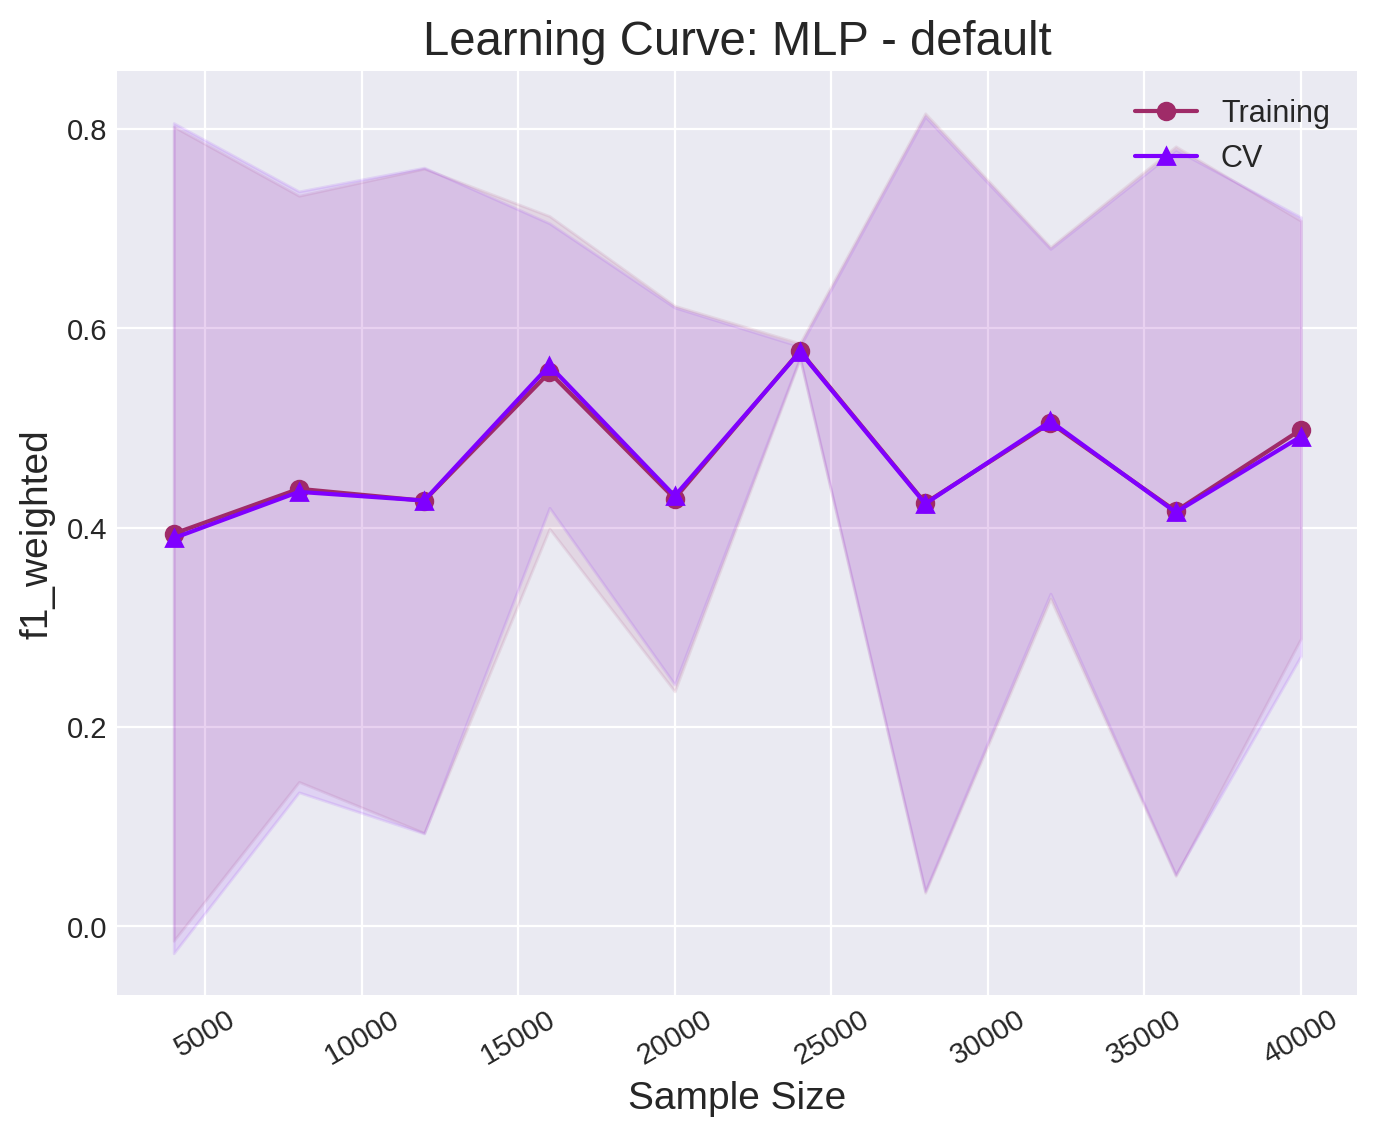

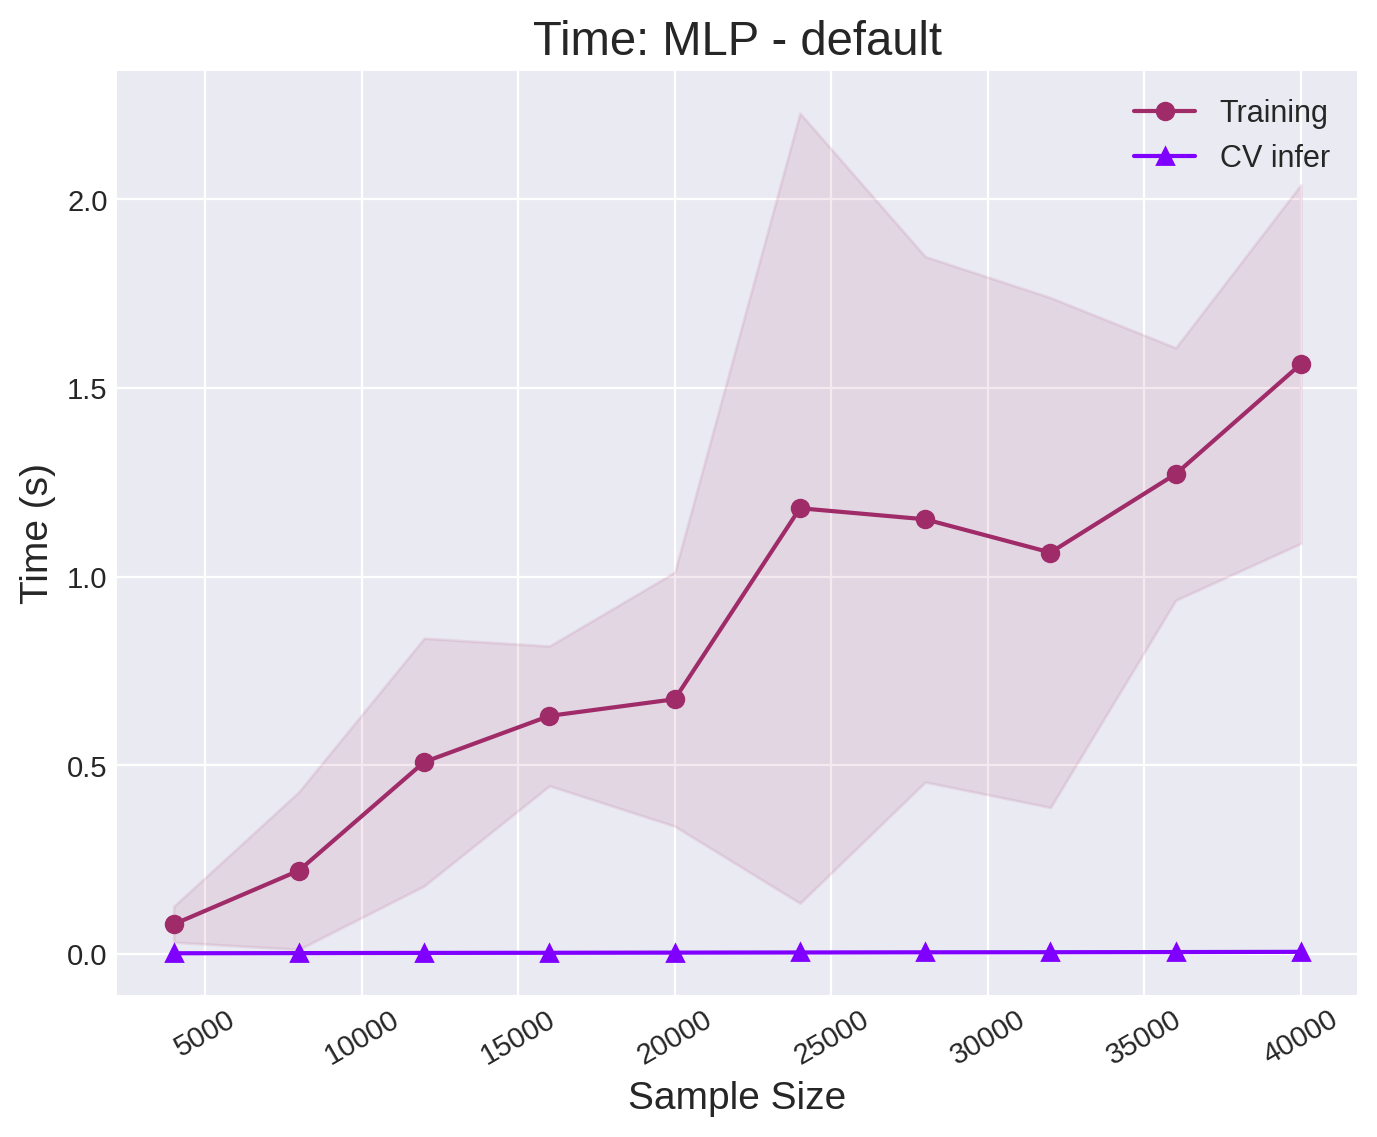

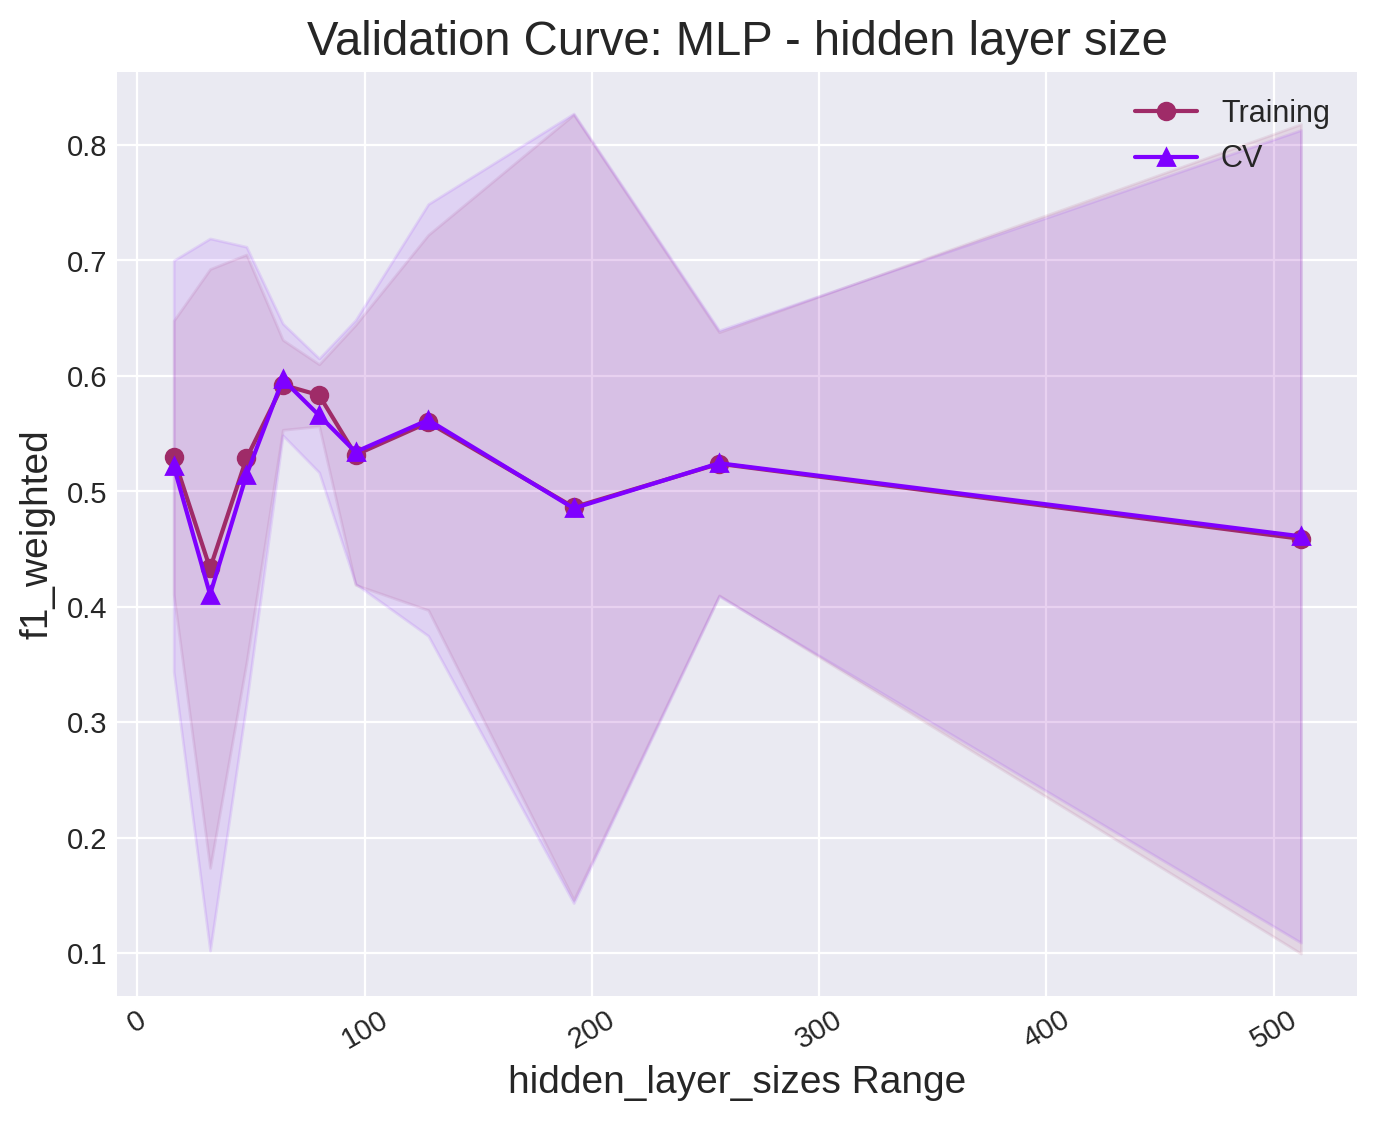

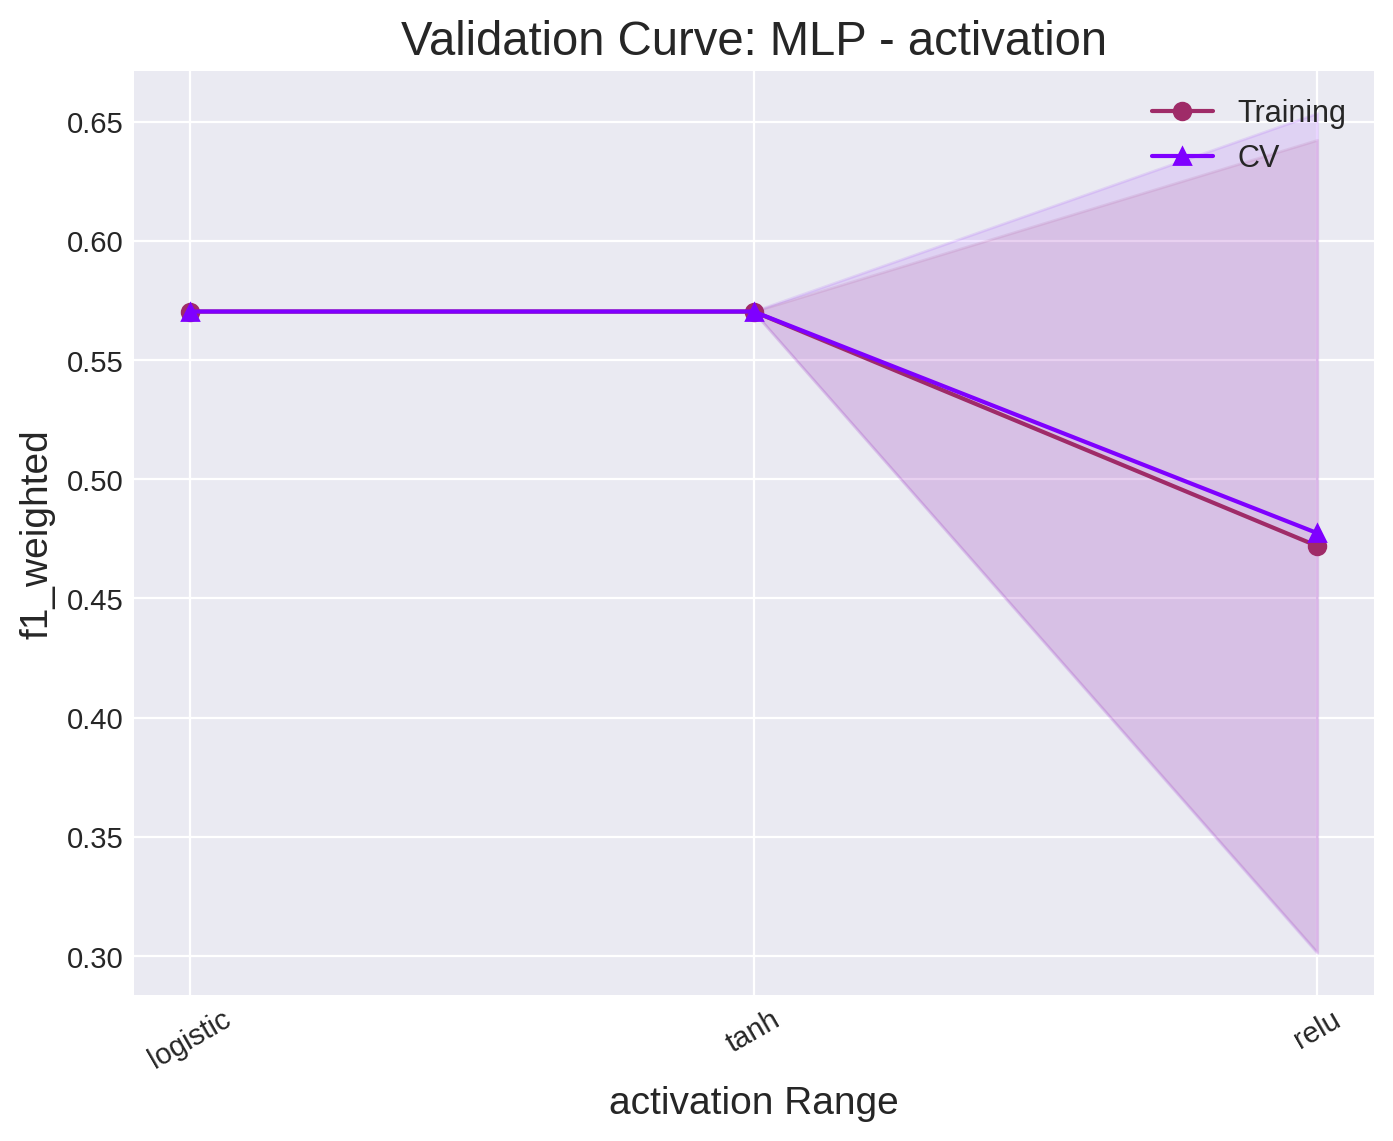

CPU times: user 8min 8s, sys: 13min 41s, total: 21min 50s
Wall time: 2min 52s


In [12]:
%%time
# experiment with number of hidden nodes and activation function
# hidden_layer_sizes_range= [(16,), (32,), (48,), (64,), (80,), (96,), (128,), (192,), (256,), (512,)]
hidden_layer_sizes_range = [16,32,48,64,80,96,128,192,256,512]
act_func_range = ['logistic', 'tanh', 'relu']
train_sizes = np.linspace(0.1, 1, 10)

clf = MLPClassifier(random_state=888)

# plot Learning curve for the default DT 
plot_learning_curve(
    clf,
    X_train.values,
    y_train.values,
    train_sizes=train_sizes,
    metric="f1_weighted",
    title="MLP - default"
)

# experiment with hidden layer size
plot_validation_curve(
    clf,
    X_train.values,
    y_train.values,
    param_name='hidden_layer_sizes',
    param_range=hidden_layer_sizes_range,
    metric="f1_weighted",
    title="MLP - hidden layer size"
)

# experiment with act function
plot_validation_curve(
    clf,
    X_train.values,
    y_train.values,
    param_name='activation',
    param_range=act_func_range ,
    metric="f1_weighted",
    title="MLP - activation"
)

In [13]:
%%time
# optimize the MLP by searching for best number of hidden units and activation function
param_grid = {
    'hidden_layer_sizes': [(48,), (64,), (80,), (96,), (128,), (192,)],
    'activation': ['logistic', 'tanh', 'relu']
    }

tuned_MLP_clf = HalvingGridSearchCV(
   estimator = MLPClassifier(random_state=888),
   param_grid=param_grid,
   cv=5,
   factor=2
   )
tuned_MLP_clf.fit(X_train, y_train)
print("With HalvingGridSearchCV, best parameters are: \n", tuned_MLP_clf.best_params_)

With HalvingGridSearchCV, best parameters are: 
 {'activation': 'logistic', 'hidden_layer_sizes': (64,)}
CPU times: user 1min 55s, sys: 3min 58s, total: 5min 54s
Wall time: 41.8 s


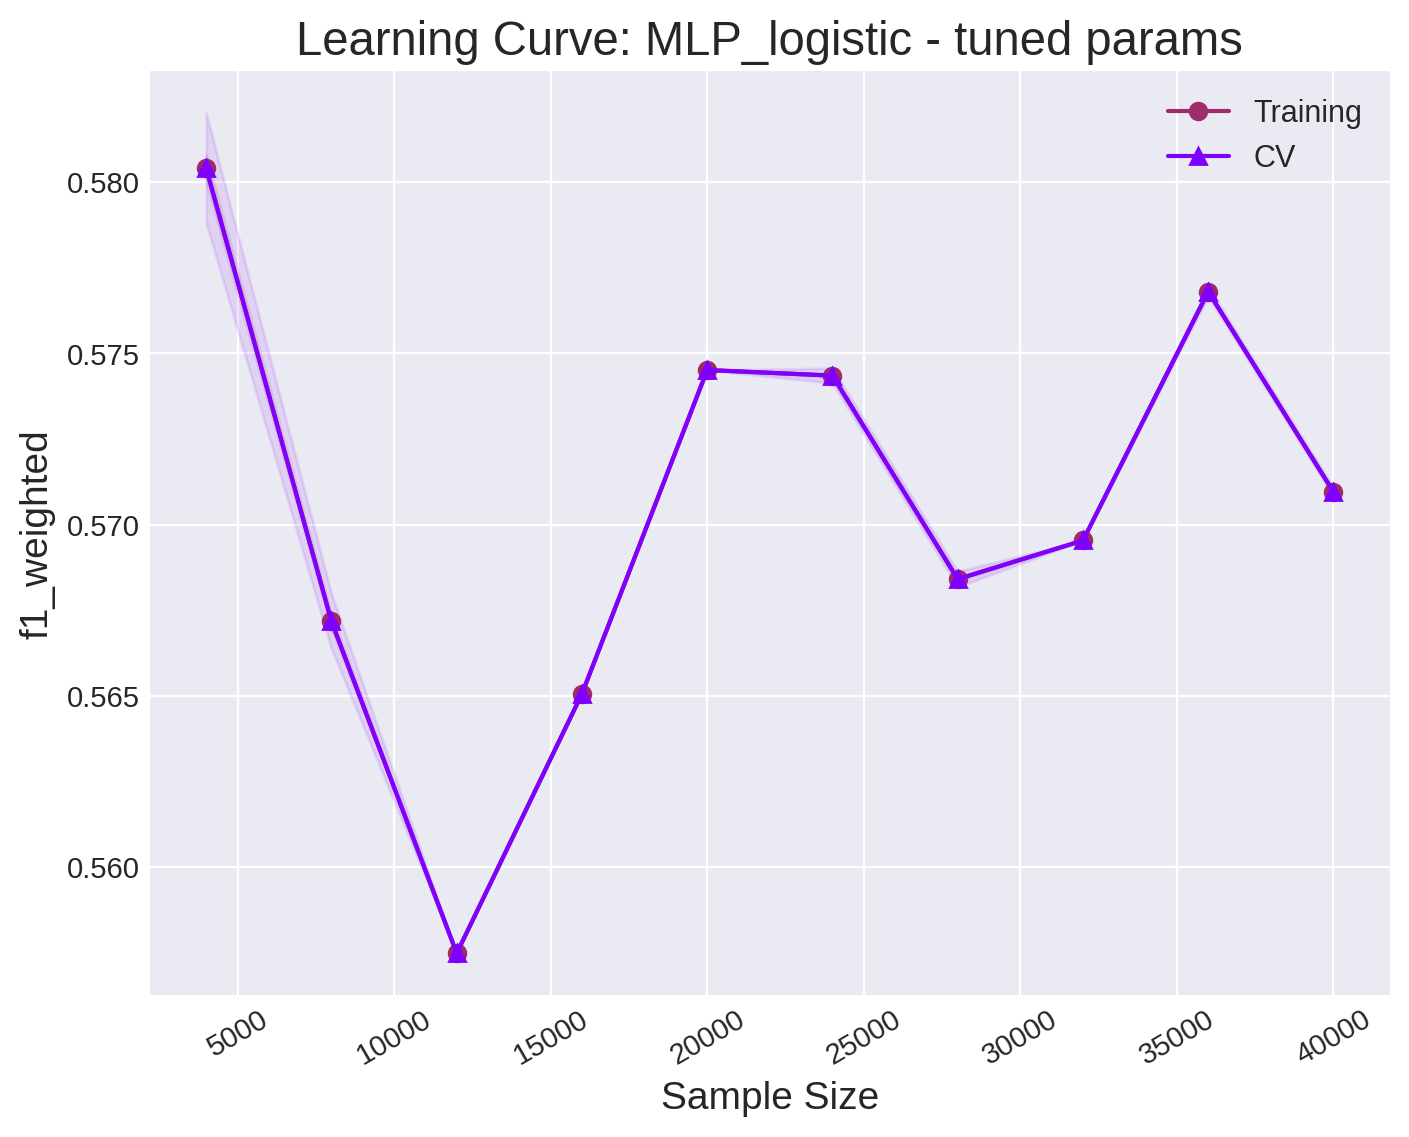

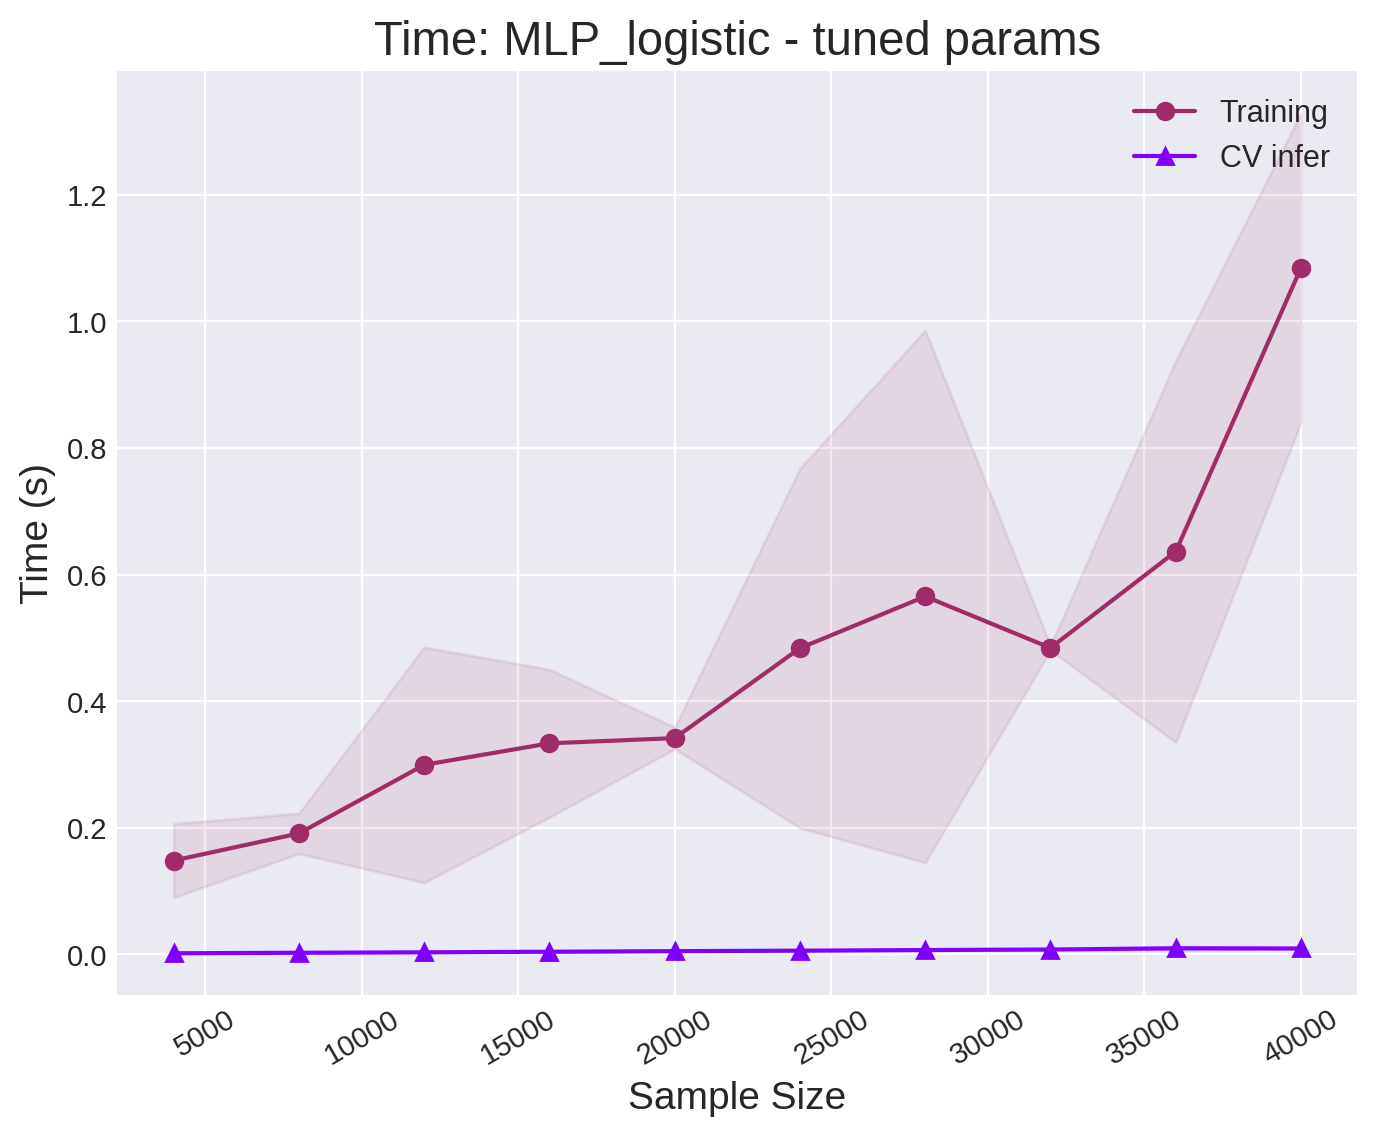

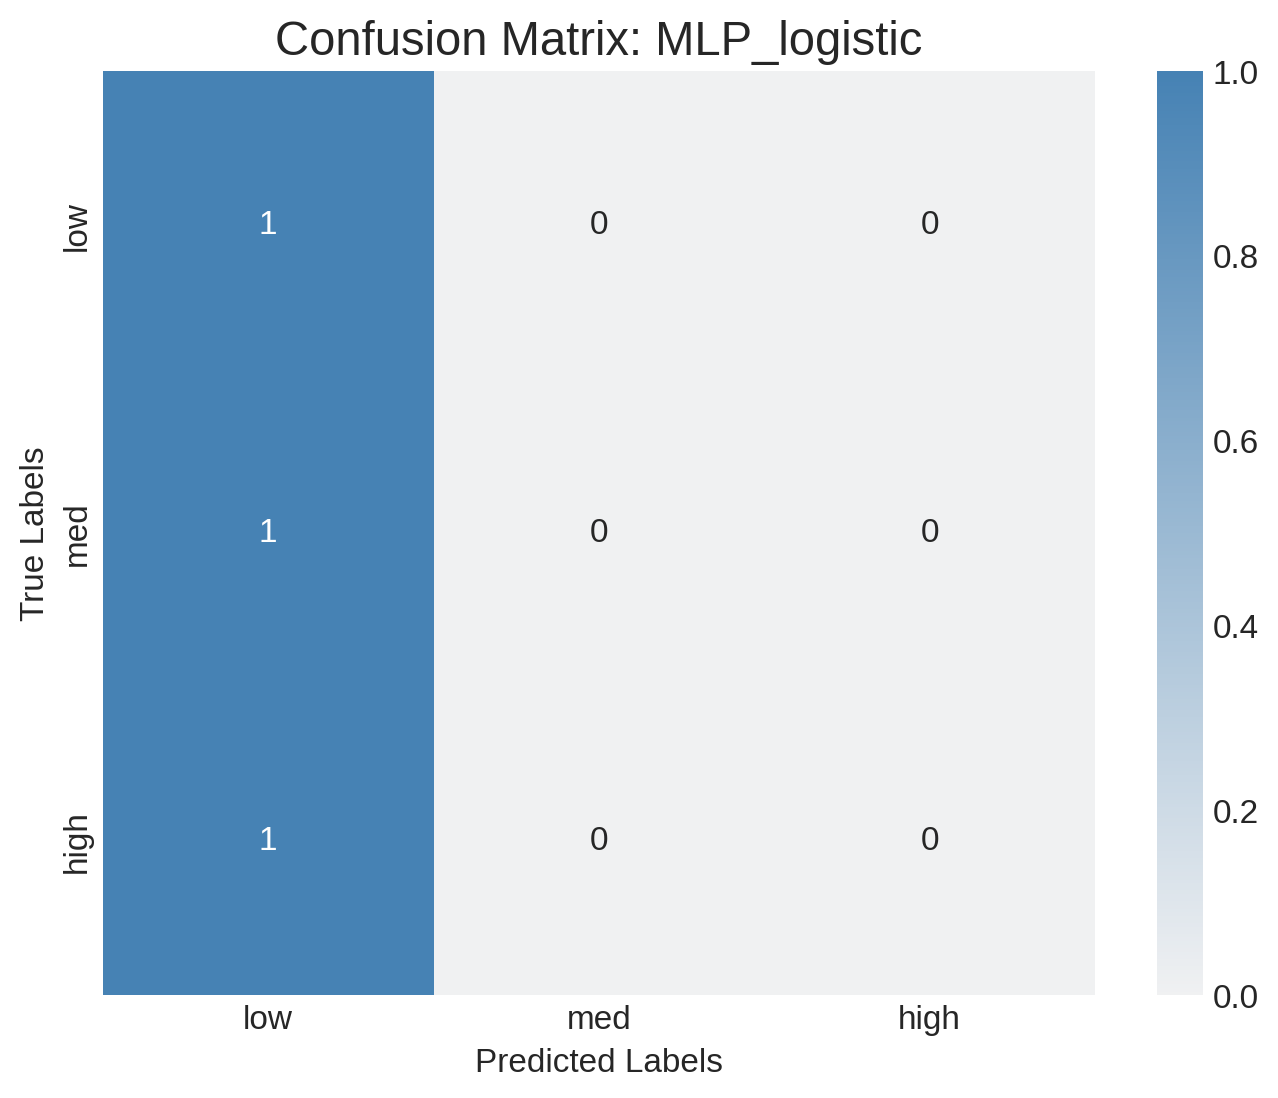

In [14]:
### Train clf on the whole training data and get learning curve
clf = MLPClassifier(
    random_state=888,
    hidden_layer_sizes=tuned_MLP_clf.best_params_['hidden_layer_sizes'],
    activation=tuned_MLP_clf.best_params_['activation']
)

# plot Learning curve for the MLP with the (supposedly) optimal params
plot_learning_curve(
    clf,
    X_train.values,
    y_train.values,
    train_sizes=train_sizes,
    metric="f1_weighted",
    title="MLP - tuned params"
)

# fit DT clf on the whole training data and making predictions
train_start_time = time.time()
clf.fit(X_train.values, y_train.values)
train_time = time.time() - train_start_time

infer_start_time = time.time()
test_preds = clf.predict(X_test.values)
infer_time = time.time() - infer_start_time

metric_score = f1_score(y_true=y_test, y_pred=test_preds, average='weighted')

conf_mat = confusion_matrix(
    y_true=y_test.values,
    y_pred=test_preds,
    labels = [0, 1, 2]
)

plot_confusion_matrix(
    conf_mat=conf_mat,
    normalize=True,
    classes=['low', 'med', 'high'],
    title="MLP")

In [15]:
MODEL_RES['model_name'].append("MLP")
MODEL_RES['metric_score'].append(metric_score)
MODEL_RES['params'].append(tuned_MLP_clf.best_params_)
MODEL_RES['train_time'].append(train_time)
MODEL_RES['infer_time'].append(infer_time)

<a id='kNN'></a>
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> kNN </h1></span>
<a href='#Index'> Back to Index</a>

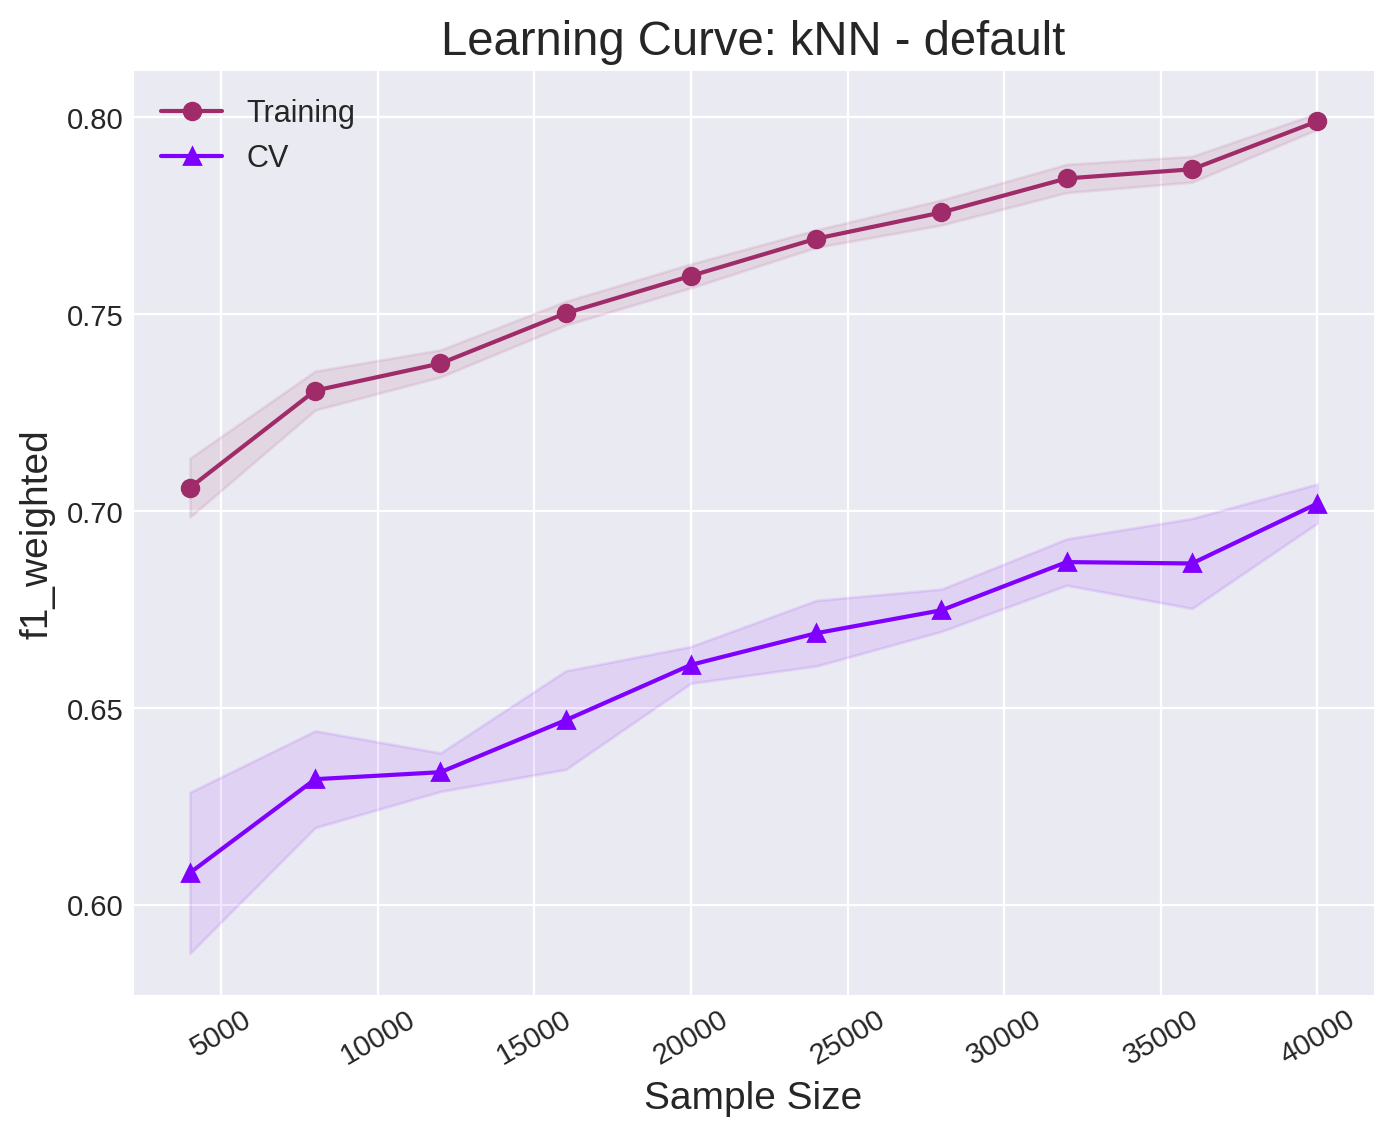

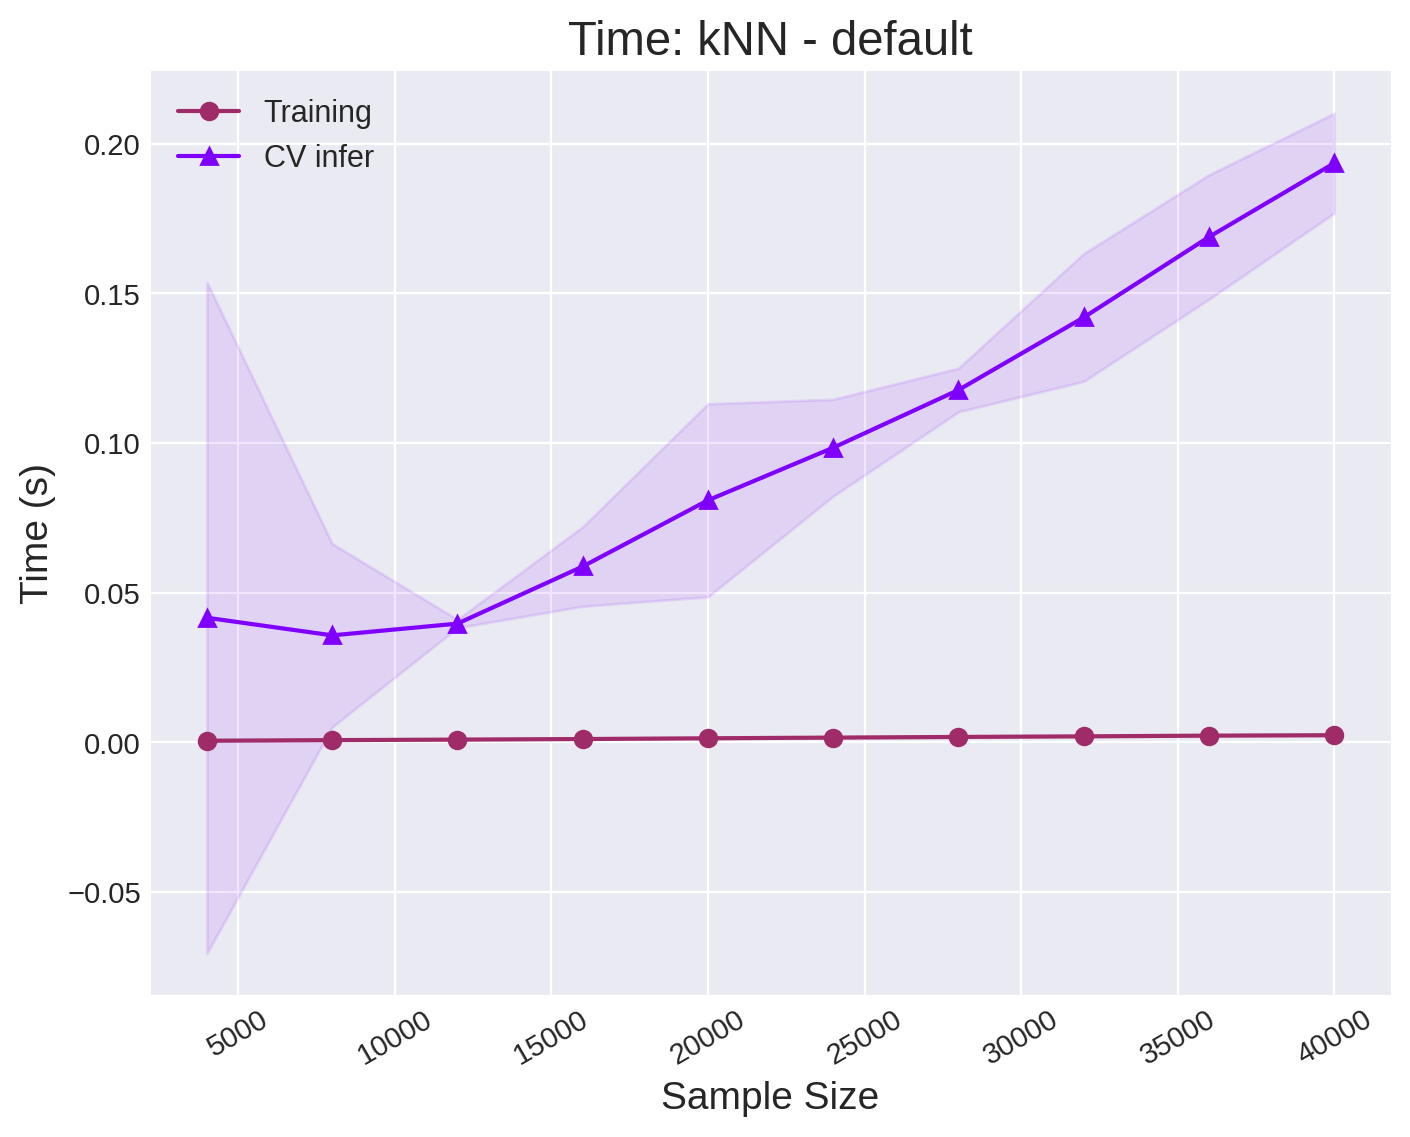

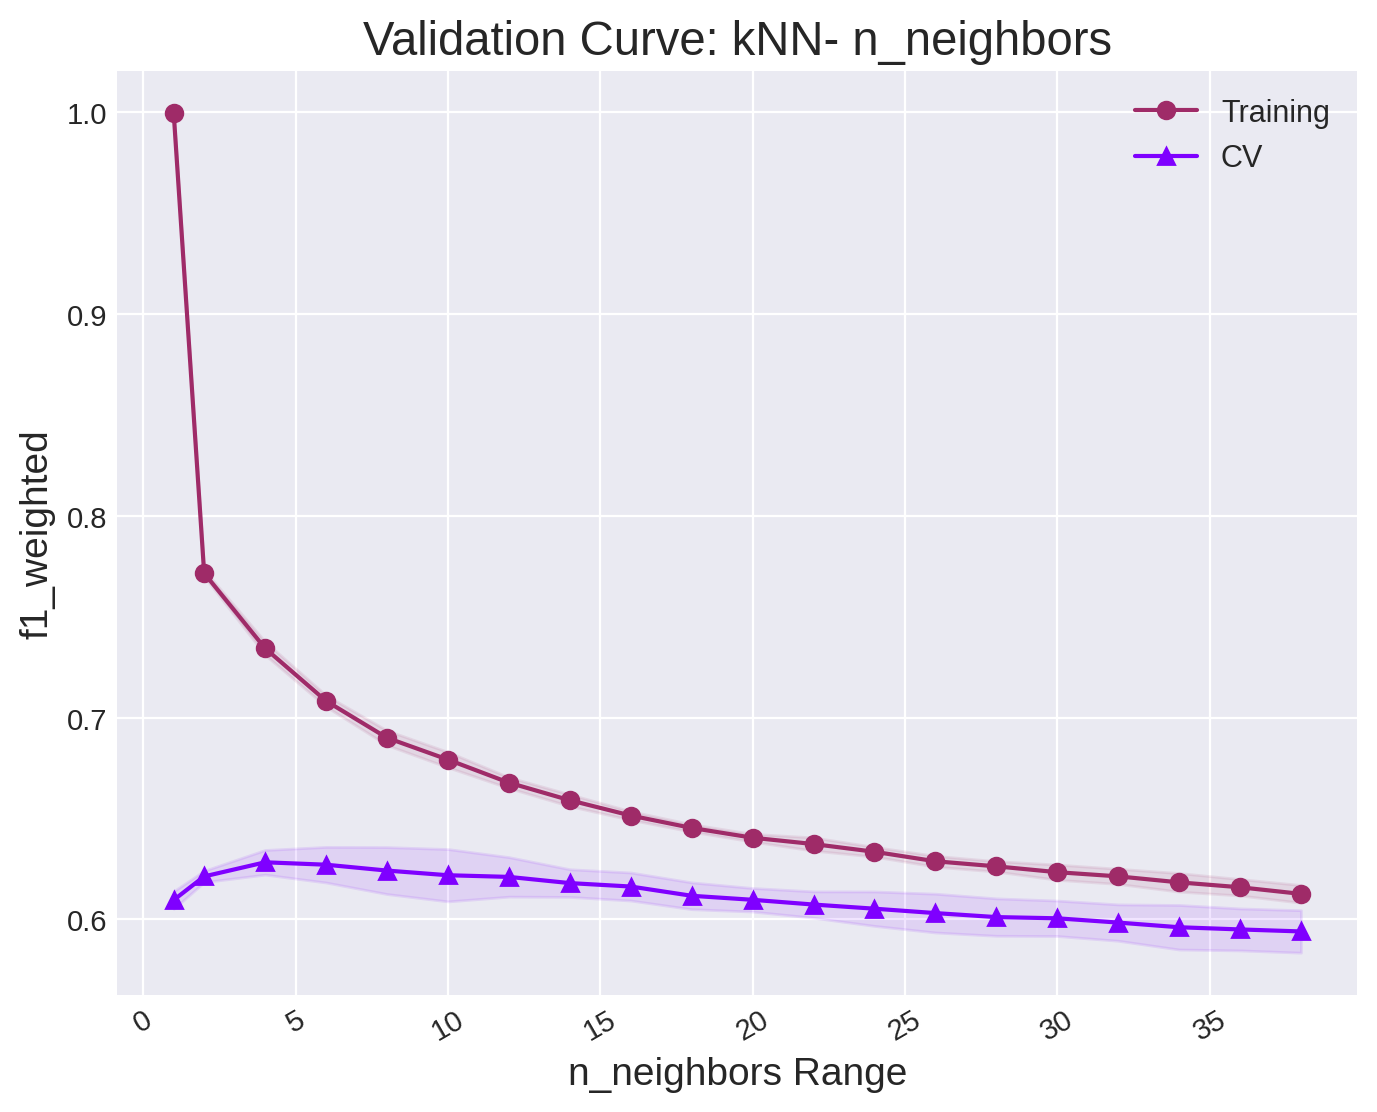

In [18]:
%%time
# experiment with n_neighbors and distance metric
n_neighbors_range = list(range(0, 40, 2))
n_neighbors_range[0] = 1
metric_range = ["minkowski", 'cityblock', 'cosine']
train_sizes = np.linspace(0.1, 1, 10)

clf = KNeighborsClassifier()

# plot Learning curve for the default knn
plot_learning_curve(
    clf,
    X_train.values,
    y_train.values,
    train_sizes=train_sizes,
    metric="f1_weighted",
    title="kNN - default"
)

# experiment with n_neighbors
plot_validation_curve(
    clf,
    X_train.values,
    y_train.values,
    param_name='n_neighbors',
    param_range=n_neighbors_range,
    metric="f1_weighted",
    title="kNN- n_neighbors"
)

# experiment with metric distance
plot_validation_curve(
    clf,
    X_train.values,
    y_train.values,
    param_name='metric',
    param_range=metric_range,
    metric="f1_weighted",
    title="kNN - metric"
)

In [ ]:
%%time
# optimize the kNN by searching n_neighbors between 1 and 10
param_grid = {
    'n_neighbors': range(1, 11),
    'metric': ["minkowski", 'cityblock', 'cosine']
    }

tuned_kNN_clf = HalvingGridSearchCV(
   estimator = KNeighborsClassifier(),
   param_grid=param_grid,
   cv=5,
   factor=2
   )
tuned_kNN_clf.fit(X_train, y_train)
print("With HalvingGridSearchCV, best parameters are: \n", tuned_kNN_clf.best_params_)

In [ ]:
### Train clf on the whole training data and get learning curve
clf = KNeighborsClassifier(
    n_neighbors=tuned_kNN_clf.best_params_['n_neighbors'],
    metric=tuned_kNN_clf.best_params_['metric']
)

# plot Learning curve for the kNN with the (supposedly) optimal params
plot_learning_curve(
    clf,
    X_train.values,
    y_train.values,
    train_sizes=train_sizes,
    metric="f1_weighted",
    title="kNN - tuned params"
)

# fit kNN clf on the whole training data and making predictions
train_start_time = time.time()
clf.fit(X_train.values, y_train.values)
train_time = time.time() - train_start_time

infer_start_time = time.time()
test_preds = clf.predict(X_test.values)
infer_time = time.time() - infer_start_time

metric_score = f1_score(y_true=y_test, y_pred=test_preds, average='weighted')

conf_mat = confusion_matrix(
    y_true=y_test.values,
    y_pred=test_preds,
    labels = [0, 1, 2]
)

plot_confusion_matrix(
    conf_mat=conf_mat,
    normalize=True,
    classes=['low', 'med', 'high'],
    title="jNN")

MODEL_RES['model_name'].append("kNN")
MODEL_RES['metric_score'].append(metric_score)
MODEL_RES['params'].append(tuned_kNN_clf.best_params_)
MODEL_RES['train_time'].append(train_time)
MODEL_RES['infer_time'].append(infer_time)

<a id='SVC'></a>
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> C-Support Vector Classifier  </h1></span>
<a href='#Index'> Back to Index</a>


In [ ]:
%%time
# experiment with regularization and kernel
C_range = np.logspace(0.01, 1, num=10)
kernel_range = ["linear", "poly", "rbf", "sigmoid"]
train_sizes = np.linspace(0.1, 1, 10)

clf = SVC()

# plot Learning curve for the default SVC
plot_learning_curve(
    clf,
    X_train.values,
    y_train.values,
    train_sizes=train_sizes,
    metric="f1_weighted",
    title="SVC - default"
)

# experiment with regularization
plot_validation_curve(
    clf,
    X_train.values,
    y_train.values,
    param_name='C',
    param_range=C_range,
    metric="f1_weighted",
    title="SVC - regularization"
)

# experiment with kernel
plot_validation_curve(
    clf,
    X_train.values,
    y_train.values,
    param_name='kernel',
    param_range=kernel_range,
    metric="f1_weighted",
    title="SVC - kernel"
)

In [ ]:
%%time
# optimize the SVC
param_grid = {
    'C': C_range,
    'kernel': kernel_range
    }

tuned_svc_clf = HalvingGridSearchCV(
   estimator = SVC(),
   param_grid=param_grid,
   cv=5,
   factor=2
   )
tuned_svc_clf.fit(X_train, y_train)
print("With HalvingGridSearchCV, best parameters are: \n", tuned_svc_clf.best_params_)

### Train clf on the whole training data and get learning curve
clf = SVC(
    C=tuned_kNN_clf.best_params_['C'],
    kernel=tuned_kNN_clf.best_params_['kernel']
)

# plot Learning curve for the SVC with the (supposedly) optimal params
plot_learning_curve(
    clf,
    X_train.values,
    y_train.values,
    train_sizes=train_sizes,
    metric="f1_weighted",
    title="kNN - tuned params"
)

# fit SVC clf on the whole training data and making predictions
train_start_time = time.time()
clf.fit(X_train.values, y_train.values)
train_time = time.time() - train_start_time

infer_start_time = time.time()
test_preds = clf.predict(X_test.values)
infer_time = time.time() - infer_start_time

metric_score = f1_score(y_true=y_test, y_pred=test_preds, average='weighted')

conf_mat = confusion_matrix(
    y_true=y_test.values,
    y_pred=test_preds,
    labels = [0, 1, 2]
)

plot_confusion_matrix(
    conf_mat=conf_mat,
    normalize=True,
    classes=['low', 'med', 'high'],
    title="SVC")

MODEL_RES['model_name'].append("SVC")
MODEL_RES['metric_score'].append(metric_score)
MODEL_RES['params'].append(tuned_SVC_clf.best_params_)
MODEL_RES['train_time'].append(train_time)
MODEL_RES['infer_time'].append(infer_time)

In [ ]:
final_res = pd.DataFrame.from_dict(MODEL_RES)
final_res